In [3]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset
from skimage import io
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
ROOT_DIR = '/kaggle/input/'
in_car_dir = 'hands-dataset-mini/images/'
hagrid_dir = 'hagrid-mini/hagrid/images/'
smoking_dir = '/kaggle/input/smoking-data/smoking_images/'

In [5]:
smoking_data = pd.read_csv('/kaggle/input/smoking-data/smoking_annotations.csv')
smoking_data['path'] = smoking_data['path'].apply(lambda path: smoking_dir + path)
smoking_data

,path,frame_width,frame_height,class,X,Y,width,height
0,/kaggle/input/smoking-data/smoking_images/003_...,474,316,Hand_cigarette,207.70,114.74,195.01,201.26
1,/kaggle/input/smoking-data/smoking_images/003_...,474,298,Hand_cigarette,164.40,150.45,101.50,147.55
2,/kaggle/input/smoking-data/smoking_images/003_...,360,433,Hand_cigarette,57.68,182.48,289.98,250.52
3,/kaggle/input/smoking-data/smoking_images/003_...,474,355,Hand_cigarette,133.49,250.18,138.76,88.44
4,/kaggle/input/smoking-data/smoking_images/003_...,474,266,Hand_cigarette,144.83,78.93,88.77,97.28
...,...,...,...,...,...,...,...,...
1977,/kaggle/input/smoking-data/smoking_images/018_...,275,183,Hand_cigarette,79.83,94.62,62.46,56.52
1978,/kaggle/input/smoking-data/smoking_images/018_...,276,183,Hand_cigarette,163.95,79.20,92.10,76.69
1979,/kaggle/input/smoking-data/smoking_images/018_...,275,183,Hand_cigarette,123.31,68.53,102.38,113.84
1980,/kaggle/input/smoking-data/smoking_images/018_...,300,168,Hand_cigarette,172.37,93.55,32.29,48.99


In [6]:
hagrid_data = pd.read_csv('/kaggle/input/hagrid-mini/hagrid/annotations.csv')
hagrid_data['path'] = hagrid_data['path'].apply(lambda path: hagrid_dir + path)
hagrid_data

,path,frame_width,frame_height,class,X,Y,width,height
0,hagrid-mini/hagrid/images/000b353f-9b45-454e-b...,1053,1276,Hand_empty,155,39,456,473
1,hagrid-mini/hagrid/images/000b9676-731b-4001-a...,788,788,Hand_empty,0,160,124,169
2,hagrid-mini/hagrid/images/000bf8d9-991d-4744-9...,634,788,Hand_empty,450,27,184,254
3,hagrid-mini/hagrid/images/000c55f3-a2c5-4dc0-9...,784,784,Hand_empty,520,165,205,269
4,hagrid-mini/hagrid/images/000de146-3f93-480d-b...,788,788,Hand_empty,528,40,260,298
...,...,...,...,...,...,...,...,...
2995,hagrid-mini/hagrid/images/2ec06634-6370-45ba-a...,777,408,Hand_empty,569,0,164,164
2996,hagrid-mini/hagrid/images/2ec0bc64-38f4-492d-8...,1368,1565,Hand_empty,207,81,267,245
2997,hagrid-mini/hagrid/images/2ecbf1d5-a85c-4751-9...,316,316,Hand_empty,271,28,45,53
2998,hagrid-mini/hagrid/images/2ecca527-c6a7-4f07-8...,863,944,Hand_empty,539,289,169,171


In [7]:
data = pd.read_csv('/kaggle/input/hands-dataset-mini/annotations.csv')
data['path'] = data['path'].apply(lambda path: in_car_dir + path)
data = data.drop(data[data['class'] == 'Hand_food'].index)
data

,path,frame_width,frame_height,class,X,Y,width,height
0,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_unknown,115.60,367.98,245.83,111.90
1,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,292.86,104.29,130.00,179.28
2,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,315.86,88.50,125.00,155.00
3,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,319.43,82.79,123.57,165.00
4,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,321.57,87.79,125.72,157.14
...,...,...,...,...,...,...,...,...
26265,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,Hand_over_wheel,195.82,1728.93,349.79,191.07
26266,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,Hand_over_wheel,201.43,1723.32,362.89,196.68
26267,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,Hand_over_wheel,186.47,1710.22,375.98,209.78
26268,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,Hand_over_wheel,178.99,1706.48,370.37,213.52


In [8]:
data = pd.concat([data, hagrid_data, smoking_data], ignore_index=True)
data

,path,frame_width,frame_height,class,X,Y,width,height
0,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_unknown,115.60,367.98,245.83,111.90
1,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,292.86,104.29,130.00,179.28
2,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,315.86,88.50,125.00,155.00
3,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,319.43,82.79,123.57,165.00
4,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,321.57,87.79,125.72,157.14
...,...,...,...,...,...,...,...,...
31223,/kaggle/input/smoking-data/smoking_images/018_...,275,183,Hand_cigarette,79.83,94.62,62.46,56.52
31224,/kaggle/input/smoking-data/smoking_images/018_...,276,183,Hand_cigarette,163.95,79.20,92.10,76.69
31225,/kaggle/input/smoking-data/smoking_images/018_...,275,183,Hand_cigarette,123.31,68.53,102.38,113.84
31226,/kaggle/input/smoking-data/smoking_images/018_...,300,168,Hand_cigarette,172.37,93.55,32.29,48.99


In [9]:
empty_images_paths = []
images = os.listdir('/kaggle/input/hands-dataset-mini/images')
for image_path in images:
    if in_car_dir + image_path not in data['path'].values:
        empty_images_paths.append(in_car_dir + image_path)

In [10]:
no_hands_data = pd.DataFrame([{'path': path,
                               'frame_width': None,
                               'frame_height': None,
                               'class': 'Not_hand',
                               'X': None,
                               'Y': None,
                               'width': None,
                               'height': None} for path in empty_images_paths])

In [11]:
no_hands_data

,path,frame_width,frame_height,class,X,Y,width,height
0,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,None,None,Not_hand,None,None,None,None
1,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,None,None,Not_hand,None,None,None,None
2,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,None,None,Not_hand,None,None,None,None
3,hands-dataset-mini/images/1fde2218-dba6-4aa1-b...,None,None,Not_hand,None,None,None,None
4,hands-dataset-mini/images/1e3e3b0d-721f-46b4-9...,None,None,Not_hand,None,None,None,None
...,...,...,...,...,...,...,...,...
25562,hands-dataset-mini/images/1d0e109f-1aa0-45bd-8...,None,None,Not_hand,None,None,None,None
25563,hands-dataset-mini/images/1a6354fd-d0d5-45a3-9...,None,None,Not_hand,None,None,None,None
25564,hands-dataset-mini/images/1e3e3b0d-721f-46b4-9...,None,None,Not_hand,None,None,None,None
25565,hands-dataset-mini/images/1e3e3b0d-721f-46b4-9...,None,None,Not_hand,None,None,None,None


In [12]:
data = pd.concat([data, no_hands_data[:10000]], ignore_index=True)

/tmp/ipykernel_34/2201229204.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, no_hands_data[:10000]], ignore_index=True)


In [13]:
data.shape

(41228, 8)

In [14]:
n_classes = len(data['class'].unique())
data['class'].unique()

array(['Hand_unknown', 'Hand_empty', 'Hand_cellular', 'Hand_over_wheel',
       'Hand_under_wheel', 'Hand_cigarette', 'Hand_vape', 'Not_hand'],
      dtype=object)

In [15]:
def plot_classes_distribution(data: pd.DataFrame):
    sns.displot(data, x='class')
    plt.xticks(rotation=30)
    plt.show()

In [16]:
torch.manual_seed(54)

## Распределение классов

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


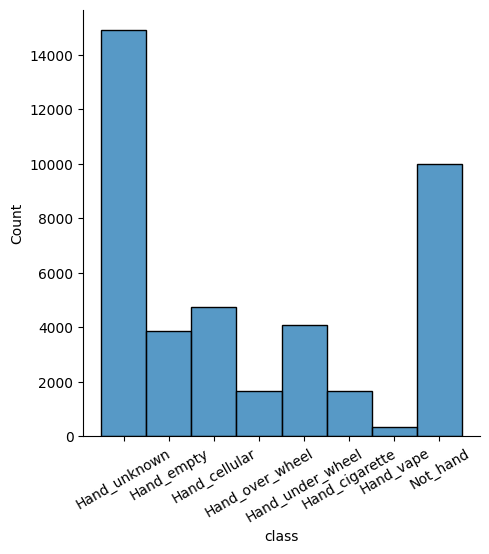

In [17]:
plot_classes_distribution(data)

## Распределение классов на картинках, где бокс не меньше 50 пикселей в длину и ширину

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


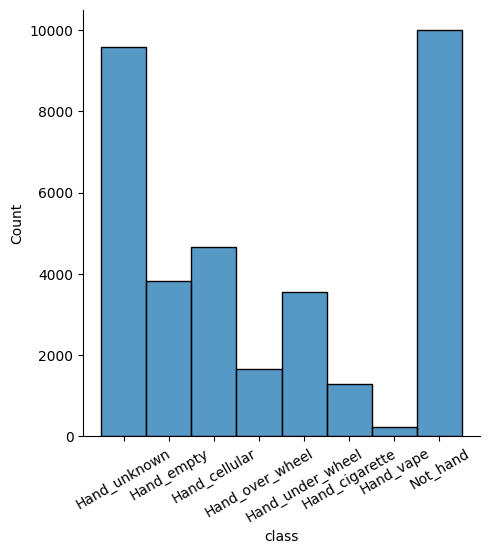

In [18]:
data = data[(data['height'] > 50) & (data['width'] > 50) | (data['class'] == 'Not_hand')]
plot_classes_distribution(data)

In [19]:
le = LabelEncoder()
data['class'] = le.fit_transform(data['class'])

In [20]:
data.head()

,path,frame_width,frame_height,class,X,Y,width,height
0,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,5,115.60,367.98,245.83,111.90
1,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,2,292.86,104.29,130.00,179.28
2,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,2,315.86,88.50,125.00,155.00
3,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,2,319.43,82.79,123.57,165.00
4,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,2,321.57,87.79,125.72,157.14


In [21]:
data.shape

(34790, 8)

In [22]:
data_copy = data.copy()

In [23]:
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(data['class'].values),
                                     y = data['class'].values)

In [24]:
class_weights = dict(zip(np.unique(data['class'].values), class_weights))

In [25]:
np.unique(data['class'].values)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [26]:
le.inverse_transform(np.unique(data['class'].values))

array(['Hand_cellular', 'Hand_cigarette', 'Hand_empty', 'Hand_over_wheel',
       'Hand_under_wheel', 'Hand_unknown', 'Hand_vape', 'Not_hand'],
      dtype=object)

In [27]:
class_weights

{0: 0.9336088449978531,
 1: 3.392160686427457,
 2: 1.1375228877844625,
 3: 2.6244719372359686,
 4: 1.2205304518664046,
 5: 0.4537983929875822,
 6: 19.4140625,
 7: 0.434875}

In [28]:
def get_random_crop(image):
    frame_width, frame_height = image.size
        
    crop_height = random.randint(120, 200)
    crop_width = random.randint(120, 200)

    x = random.randint(0, frame_width - crop_width)
    y = random.randint(0, frame_height - crop_height)

    crop_area = (x, y, x + crop_width, y + crop_height)
    return image.crop(crop_area)

## Создание датасета

In [29]:
class DriverHandsDataset(Dataset):
    def __init__(self, annotations: pd.DataFrame, root_dir, transform=None):
        self.annotations = annotations
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        # image = io.imread(img_path)
        image = Image.open(img_path)
        
        y_label = torch.tensor(int(self.annotations.iloc[index]['class']))
        
        if le.inverse_transform([y_label.item()])[0] == 'Not_hand':
            image = get_random_crop(image)
            
        else:
            x, y, width, height, frame_width, frame_height = (self.annotations.iloc[index]['X'], 
                                   self.annotations.iloc[index]['Y'],
                                   self.annotations.iloc[index]['width'],
                                   self.annotations.iloc[index]['height'],
                                   self.annotations.iloc[index]['frame_width'],
                                   self.annotations.iloc[index]['frame_height'])

            crop_area = (max(0, x - random.randint(10, 30)),
                         max(0, y - random.randint(10, 30)),
                         min(x + width + random.randint(10, 30), frame_width),
                         min(y + height + random.randint(10, 30), frame_height))
            image = image.crop(crop_area)
        
        if self.transform:
            image = self.transform(image)
            
        return image, y_label

In [30]:
dataset = DriverHandsDataset(data, ROOT_DIR)

In [32]:
dataset[30000]

(<PIL.Image.Image image mode=RGB size=177x153>, tensor(7))

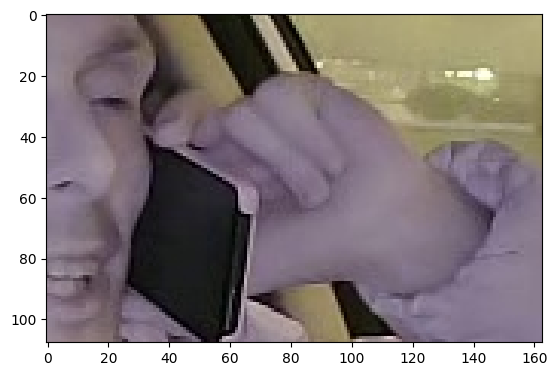

In [34]:
random_index = random.randint(0, len(dataset) - 1) 
  
# Plotting the randomly selected image 
plt.imshow(dataset[random_index][0])
plt.show()

In [31]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomRotation((-60, 60))])

In [32]:
dataset = DriverHandsDataset(data, ROOT_DIR, transform=transform)

In [33]:
generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(dataset, [0.7, 0.3], generator)
train_dataset, val_dataset = random_split(train_dataset, [0.85, 0.15], generator)

In [34]:
device = 'cuda'

In [35]:
batch_size = 32

trainloader = DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)
valloader = DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=False)

# Обучение DenseNet121

In [36]:
densenet = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
densenet.classifier = nn.Linear(in_features=1024, out_features=n_classes, bias=True)

# for param in densenet.parameters():
#     param.requires_grad = False
    
# for param in densenet.classifier.parameters():
#     param.requires_grad = True
# densenet.load_state_dict(torch.load('/kaggle/working/densenet_mini_data.pt'))
# densenet.load_state_dict(torch.load('/kaggle/working/densenet_mini_data_with_hagrid.pt'))
# densenet.load_state_dict(torch.load('/kaggle/working/densenet121_full_data.pt'))
densenet = densenet.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 142MB/s]


In [37]:
torch.Tensor(list(class_weights.values()))

tensor([ 0.9336,  3.3922,  1.1375,  2.6245,  1.2205,  0.4538, 19.4141,  0.4349])

In [38]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).to(device))
optimizer = optim.SGD(densenet.parameters(), lr=0.001, momentum=0.9)

In [39]:
def validate(model):
    model.eval()
    sum_loss = 0
    for data in tqdm(valloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
    #         print(images.shape)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()
        
    return sum_loss /  len(valloader)

In [40]:
def train(model, criterion, optimizer, model_name, n_epochs=2):
    model.train()
    least_val_loss = None
    training_losses = []
    val_losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        losses = []
        running_loss = 0.0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            losses.append(loss.item())
            if i % 20 == 19:    # print every 20 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
                running_loss = 0.0
                
        training_losses.append(np.mean(losses))
        val_loss = validate(model)
        print(f'[{epoch + 1}] val loss: {val_loss}')
        
        val_losses.append(val_loss)
        
        if least_val_loss is None or val_loss < least_val_loss:
            least_val_loss = val_loss
            torch.save(model.state_dict(), f'/kaggle/working/{model_name}_best_result.pt')
            print('Saving model...')
        

    print('Finished Training')
    return training_losses, val_losses

In [41]:
dn121_train_losses, dn121_val_losses = train(densenet, criterion, optimizer, model_name='DenseNet121', n_epochs=8)

  3%|▎         | 20/647 [00:21<10:09,  1.03it/s]

[1,    20] loss: 1.912


  6%|▌         | 40/647 [00:42<10:28,  1.04s/it]

[1,    40] loss: 1.351


  9%|▉         | 60/647 [01:03<10:23,  1.06s/it]

[1,    60] loss: 0.794


 12%|█▏        | 80/647 [01:24<09:49,  1.04s/it]

[1,    80] loss: 0.698


 15%|█▌        | 100/647 [01:46<09:16,  1.02s/it]

[1,   100] loss: 0.680


 19%|█▊        | 120/647 [02:06<09:26,  1.08s/it]

[1,   120] loss: 0.714


 22%|██▏       | 140/647 [02:27<08:21,  1.01it/s]

[1,   140] loss: 0.490


 25%|██▍       | 160/647 [02:47<08:00,  1.01it/s]

[1,   160] loss: 0.791


 28%|██▊       | 180/647 [03:07<07:46,  1.00it/s]

[1,   180] loss: 0.468


 31%|███       | 200/647 [03:26<07:23,  1.01it/s]

[1,   200] loss: 0.450


 34%|███▍      | 220/647 [03:47<07:16,  1.02s/it]

[1,   220] loss: 0.465


 37%|███▋      | 240/647 [04:07<06:43,  1.01it/s]

[1,   240] loss: 0.508


 40%|████      | 260/647 [04:27<06:19,  1.02it/s]

[1,   260] loss: 0.413


 43%|████▎     | 280/647 [04:47<06:07,  1.00s/it]

[1,   280] loss: 0.356


 46%|████▋     | 300/647 [05:07<05:51,  1.01s/it]

[1,   300] loss: 0.415


 49%|████▉     | 320/647 [05:27<05:35,  1.03s/it]

[1,   320] loss: 0.357


 53%|█████▎    | 340/647 [05:47<05:02,  1.01it/s]

[1,   340] loss: 0.549


 56%|█████▌    | 360/647 [06:07<04:53,  1.02s/it]

[1,   360] loss: 0.411


 59%|█████▊    | 380/647 [06:27<04:27,  1.00s/it]

[1,   380] loss: 0.406


 62%|██████▏   | 400/647 [06:47<04:11,  1.02s/it]

[1,   400] loss: 0.249


 65%|██████▍   | 420/647 [07:06<03:35,  1.05it/s]

[1,   420] loss: 0.416


 68%|██████▊   | 440/647 [07:26<03:24,  1.01it/s]

[1,   440] loss: 0.324


 71%|███████   | 460/647 [07:45<03:03,  1.02it/s]

[1,   460] loss: 0.371


 74%|███████▍  | 480/647 [08:05<02:48,  1.01s/it]

[1,   480] loss: 0.323


 77%|███████▋  | 500/647 [08:25<02:23,  1.02it/s]

[1,   500] loss: 0.293


 80%|████████  | 520/647 [08:46<02:05,  1.01it/s]

[1,   520] loss: 0.339


 83%|████████▎ | 540/647 [09:06<01:47,  1.00s/it]

[1,   540] loss: 0.258


 87%|████████▋ | 560/647 [09:26<01:26,  1.01it/s]

[1,   560] loss: 0.237


 90%|████████▉ | 580/647 [09:46<01:06,  1.00it/s]

[1,   580] loss: 0.361


 93%|█████████▎| 600/647 [10:06<00:46,  1.01it/s]

[1,   600] loss: 0.312


 96%|█████████▌| 620/647 [10:25<00:26,  1.02it/s]

[1,   620] loss: 0.199


 99%|█████████▉| 640/647 [10:45<00:06,  1.03it/s]

[1,   640] loss: 0.315


100%|██████████| 115/115 [01:39<00:00,  1.15it/s]


[1] val loss: 0.27087118421559747
Saving model...


  3%|▎         | 20/647 [00:12<06:27,  1.62it/s]

[2,    20] loss: 0.817


  6%|▌         | 40/647 [00:24<06:17,  1.61it/s]

[2,    40] loss: 1.382


  9%|▉         | 60/647 [00:37<05:56,  1.65it/s]

[2,    60] loss: 1.369


 12%|█▏        | 80/647 [00:50<05:49,  1.62it/s]

[2,    80] loss: 0.963


 15%|█▌        | 100/647 [01:02<05:40,  1.61it/s]

[2,   100] loss: 0.824


 19%|█▊        | 120/647 [01:15<05:31,  1.59it/s]

[2,   120] loss: 0.614


 22%|██▏       | 140/647 [01:27<05:12,  1.62it/s]

[2,   140] loss: 0.741


 25%|██▍       | 160/647 [01:40<05:07,  1.59it/s]

[2,   160] loss: 0.700


 28%|██▊       | 180/647 [01:52<04:48,  1.62it/s]

[2,   180] loss: 0.484


 31%|███       | 200/647 [02:05<04:42,  1.58it/s]

[2,   200] loss: 0.514


 34%|███▍      | 220/647 [02:18<04:32,  1.57it/s]

[2,   220] loss: 0.546


 37%|███▋      | 240/647 [02:31<04:24,  1.54it/s]

[2,   240] loss: 0.472


 40%|████      | 260/647 [02:43<03:57,  1.63it/s]

[2,   260] loss: 0.552


 43%|████▎     | 280/647 [02:55<03:48,  1.61it/s]

[2,   280] loss: 0.633


 46%|████▋     | 300/647 [03:08<03:36,  1.60it/s]

[2,   300] loss: 0.514


 49%|████▉     | 320/647 [03:21<03:31,  1.55it/s]

[2,   320] loss: 0.660


 53%|█████▎    | 340/647 [03:34<03:27,  1.48it/s]

[2,   340] loss: 0.521


 56%|█████▌    | 360/647 [03:46<02:57,  1.62it/s]

[2,   360] loss: 0.857


 59%|█████▊    | 380/647 [03:59<02:44,  1.62it/s]

[2,   380] loss: 0.688


 62%|██████▏   | 400/647 [04:11<02:36,  1.58it/s]

[2,   400] loss: 0.734


 65%|██████▍   | 420/647 [04:24<02:23,  1.58it/s]

[2,   420] loss: 0.554


 68%|██████▊   | 440/647 [04:37<02:16,  1.52it/s]

[2,   440] loss: 0.506


 71%|███████   | 460/647 [04:49<01:56,  1.60it/s]

[2,   460] loss: 0.383


 74%|███████▍  | 480/647 [05:02<01:40,  1.66it/s]

[2,   480] loss: 0.421


 77%|███████▋  | 500/647 [05:15<01:33,  1.57it/s]

[2,   500] loss: 0.295


 80%|████████  | 520/647 [05:28<01:22,  1.54it/s]

[2,   520] loss: 0.418


 83%|████████▎ | 540/647 [05:41<01:10,  1.51it/s]

[2,   540] loss: 0.591


 87%|████████▋ | 560/647 [05:53<00:54,  1.60it/s]

[2,   560] loss: 0.345


 90%|████████▉ | 580/647 [06:06<00:41,  1.60it/s]

[2,   580] loss: 0.449


 93%|█████████▎| 600/647 [06:19<00:30,  1.53it/s]

[2,   600] loss: 0.415


 96%|█████████▌| 620/647 [06:31<00:16,  1.62it/s]

[2,   620] loss: 0.386


 99%|█████████▉| 640/647 [06:44<00:04,  1.54it/s]

[2,   640] loss: 0.400


100%|██████████| 115/115 [00:58<00:00,  1.96it/s]


[2] val loss: 0.2865084538317245


  3%|▎         | 20/647 [00:12<06:32,  1.60it/s]

[3,    20] loss: 0.381


  6%|▌         | 40/647 [00:25<06:46,  1.49it/s]

[3,    40] loss: 0.211


  9%|▉         | 60/647 [00:38<06:12,  1.58it/s]

[3,    60] loss: 0.310


 12%|█▏        | 80/647 [00:50<05:56,  1.59it/s]

[3,    80] loss: 0.444


 15%|█▌        | 100/647 [01:03<05:29,  1.66it/s]

[3,   100] loss: 0.299


 19%|█▊        | 120/647 [01:15<05:26,  1.61it/s]

[3,   120] loss: 0.319


 22%|██▏       | 140/647 [01:27<05:18,  1.59it/s]

[3,   140] loss: 0.258


 25%|██▍       | 160/647 [01:40<05:00,  1.62it/s]

[3,   160] loss: 0.493


 28%|██▊       | 180/647 [01:52<04:49,  1.61it/s]

[3,   180] loss: 0.392


 31%|███       | 200/647 [02:05<04:45,  1.56it/s]

[3,   200] loss: 0.324


 34%|███▍      | 220/647 [02:17<04:23,  1.62it/s]

[3,   220] loss: 0.335


 37%|███▋      | 240/647 [02:30<04:27,  1.52it/s]

[3,   240] loss: 0.295


 40%|████      | 260/647 [02:43<03:58,  1.62it/s]

[3,   260] loss: 0.251


 43%|████▎     | 280/647 [02:55<03:40,  1.66it/s]

[3,   280] loss: 0.414


 46%|████▋     | 300/647 [03:08<03:33,  1.62it/s]

[3,   300] loss: 0.373


 49%|████▉     | 320/647 [03:20<03:17,  1.65it/s]

[3,   320] loss: 0.370


 53%|█████▎    | 340/647 [03:33<03:08,  1.63it/s]

[3,   340] loss: 0.386


 56%|█████▌    | 360/647 [03:45<03:02,  1.57it/s]

[3,   360] loss: 0.381


 59%|█████▊    | 380/647 [03:57<02:43,  1.63it/s]

[3,   380] loss: 0.309


 62%|██████▏   | 400/647 [04:10<02:29,  1.65it/s]

[3,   400] loss: 0.255


 65%|██████▍   | 420/647 [04:22<02:20,  1.61it/s]

[3,   420] loss: 0.284


 68%|██████▊   | 440/647 [04:35<02:12,  1.56it/s]

[3,   440] loss: 0.242


 71%|███████   | 460/647 [04:48<02:04,  1.50it/s]

[3,   460] loss: 0.319


 74%|███████▍  | 480/647 [05:01<01:47,  1.55it/s]

[3,   480] loss: 0.313


 77%|███████▋  | 500/647 [05:14<01:30,  1.62it/s]

[3,   500] loss: 0.357


 80%|████████  | 520/647 [05:26<01:21,  1.55it/s]

[3,   520] loss: 0.304


 83%|████████▎ | 540/647 [05:39<01:04,  1.67it/s]

[3,   540] loss: 0.302


 87%|████████▋ | 560/647 [05:51<00:54,  1.60it/s]

[3,   560] loss: 0.222


 90%|████████▉ | 580/647 [06:04<00:41,  1.63it/s]

[3,   580] loss: 0.365


 93%|█████████▎| 600/647 [06:16<00:29,  1.61it/s]

[3,   600] loss: 0.341


 96%|█████████▌| 620/647 [06:29<00:17,  1.56it/s]

[3,   620] loss: 0.322


 99%|█████████▉| 640/647 [06:42<00:04,  1.53it/s]

[3,   640] loss: 0.221


100%|██████████| 115/115 [00:59<00:00,  1.93it/s]


[3] val loss: 0.27299112483211185


  3%|▎         | 20/647 [00:12<06:16,  1.66it/s]

[4,    20] loss: 0.256


  6%|▌         | 40/647 [00:24<06:01,  1.68it/s]

[4,    40] loss: 0.218


  9%|▉         | 60/647 [00:36<05:49,  1.68it/s]

[4,    60] loss: 0.201


 12%|█▏        | 80/647 [00:49<05:45,  1.64it/s]

[4,    80] loss: 0.333


 15%|█▌        | 100/647 [01:01<05:46,  1.58it/s]

[4,   100] loss: 0.271


 19%|█▊        | 120/647 [01:13<05:11,  1.69it/s]

[4,   120] loss: 0.294


 22%|██▏       | 140/647 [01:25<05:12,  1.62it/s]

[4,   140] loss: 0.255


 25%|██▍       | 160/647 [01:38<04:55,  1.65it/s]

[4,   160] loss: 0.274


 28%|██▊       | 180/647 [01:50<04:56,  1.57it/s]

[4,   180] loss: 0.310


 31%|███       | 200/647 [02:02<04:28,  1.66it/s]

[4,   200] loss: 0.303


 34%|███▍      | 220/647 [02:15<04:16,  1.67it/s]

[4,   220] loss: 0.238


 37%|███▋      | 240/647 [02:27<04:17,  1.58it/s]

[4,   240] loss: 0.272


 40%|████      | 260/647 [02:40<03:57,  1.63it/s]

[4,   260] loss: 0.284


 43%|████▎     | 280/647 [02:52<03:54,  1.56it/s]

[4,   280] loss: 0.195


 46%|████▋     | 300/647 [03:05<03:31,  1.64it/s]

[4,   300] loss: 0.179


 49%|████▉     | 320/647 [03:17<03:37,  1.50it/s]

[4,   320] loss: 0.271


 53%|█████▎    | 340/647 [03:30<03:17,  1.55it/s]

[4,   340] loss: 0.225


 56%|█████▌    | 360/647 [03:43<02:52,  1.66it/s]

[4,   360] loss: 0.207


 59%|█████▊    | 380/647 [03:55<02:49,  1.58it/s]

[4,   380] loss: 0.224


 62%|██████▏   | 400/647 [04:08<02:43,  1.51it/s]

[4,   400] loss: 0.231


 65%|██████▍   | 420/647 [04:21<02:22,  1.60it/s]

[4,   420] loss: 0.202


 68%|██████▊   | 440/647 [04:33<02:10,  1.59it/s]

[4,   440] loss: 0.240


 71%|███████   | 460/647 [04:46<01:59,  1.57it/s]

[4,   460] loss: 0.165


 74%|███████▍  | 480/647 [04:59<01:46,  1.56it/s]

[4,   480] loss: 0.224


 77%|███████▋  | 500/647 [05:12<01:38,  1.50it/s]

[4,   500] loss: 0.279


 80%|████████  | 520/647 [05:25<01:24,  1.51it/s]

[4,   520] loss: 0.337


 83%|████████▎ | 540/647 [05:38<01:08,  1.55it/s]

[4,   540] loss: 0.249


 87%|████████▋ | 560/647 [05:51<00:54,  1.58it/s]

[4,   560] loss: 0.275


 90%|████████▉ | 580/647 [06:03<00:42,  1.57it/s]

[4,   580] loss: 0.250


 93%|█████████▎| 600/647 [06:16<00:30,  1.55it/s]

[4,   600] loss: 0.179


 96%|█████████▌| 620/647 [06:29<00:17,  1.57it/s]

[4,   620] loss: 0.277


 99%|█████████▉| 640/647 [06:42<00:04,  1.52it/s]

[4,   640] loss: 0.332


100%|██████████| 115/115 [01:00<00:00,  1.90it/s]


[4] val loss: 0.2616661013144514
Saving model...


  3%|▎         | 20/647 [00:12<06:26,  1.62it/s]

[5,    20] loss: 0.237


  6%|▌         | 40/647 [00:24<06:17,  1.61it/s]

[5,    40] loss: 0.203


  9%|▉         | 60/647 [00:37<06:17,  1.55it/s]

[5,    60] loss: 0.262


 12%|█▏        | 80/647 [00:49<05:44,  1.64it/s]

[5,    80] loss: 0.280


 15%|█▌        | 100/647 [01:02<06:05,  1.50it/s]

[5,   100] loss: 0.187


 19%|█▊        | 120/647 [01:15<05:23,  1.63it/s]

[5,   120] loss: 0.226


 22%|██▏       | 140/647 [01:28<05:35,  1.51it/s]

[5,   140] loss: 0.149


 25%|██▍       | 160/647 [01:41<05:12,  1.56it/s]

[5,   160] loss: 0.173


 28%|██▊       | 180/647 [01:53<04:55,  1.58it/s]

[5,   180] loss: 0.248


 31%|███       | 200/647 [02:06<04:43,  1.58it/s]

[5,   200] loss: 0.265


 34%|███▍      | 220/647 [02:18<04:34,  1.56it/s]

[5,   220] loss: 0.169


 37%|███▋      | 240/647 [02:30<04:08,  1.64it/s]

[5,   240] loss: 0.300


 40%|████      | 260/647 [02:43<04:04,  1.58it/s]

[5,   260] loss: 0.131


 43%|████▎     | 280/647 [02:56<03:49,  1.60it/s]

[5,   280] loss: 0.210


 46%|████▋     | 300/647 [03:09<03:38,  1.58it/s]

[5,   300] loss: 0.147


 49%|████▉     | 320/647 [03:21<03:18,  1.65it/s]

[5,   320] loss: 0.176


 53%|█████▎    | 340/647 [03:33<03:08,  1.63it/s]

[5,   340] loss: 0.145


 56%|█████▌    | 360/647 [03:46<03:06,  1.54it/s]

[5,   360] loss: 0.181


 59%|█████▊    | 380/647 [03:59<02:51,  1.55it/s]

[5,   380] loss: 0.219


 62%|██████▏   | 400/647 [04:12<02:37,  1.57it/s]

[5,   400] loss: 0.287


 65%|██████▍   | 420/647 [04:25<02:16,  1.66it/s]

[5,   420] loss: 0.215


 68%|██████▊   | 440/647 [04:37<02:14,  1.54it/s]

[5,   440] loss: 0.209


 71%|███████   | 460/647 [04:50<01:58,  1.57it/s]

[5,   460] loss: 0.170


 74%|███████▍  | 480/647 [05:03<01:46,  1.57it/s]

[5,   480] loss: 0.205


 77%|███████▋  | 500/647 [05:16<01:34,  1.56it/s]

[5,   500] loss: 0.315


 80%|████████  | 520/647 [05:28<01:18,  1.61it/s]

[5,   520] loss: 0.268


 83%|████████▎ | 540/647 [05:41<01:10,  1.52it/s]

[5,   540] loss: 0.208


 87%|████████▋ | 560/647 [05:54<00:55,  1.56it/s]

[5,   560] loss: 0.200


 90%|████████▉ | 580/647 [06:07<00:41,  1.60it/s]

[5,   580] loss: 0.218


 93%|█████████▎| 600/647 [06:20<00:30,  1.53it/s]

[5,   600] loss: 0.126


 96%|█████████▌| 620/647 [06:33<00:17,  1.55it/s]

[5,   620] loss: 0.217


 99%|█████████▉| 640/647 [06:46<00:04,  1.46it/s]

[5,   640] loss: 0.110


100%|██████████| 115/115 [00:58<00:00,  1.96it/s]


[5] val loss: 0.35476903102320173


  3%|▎         | 20/647 [00:12<06:22,  1.64it/s]

[6,    20] loss: 0.099


  6%|▌         | 40/647 [00:25<06:22,  1.59it/s]

[6,    40] loss: 0.327


  9%|▉         | 60/647 [00:38<06:13,  1.57it/s]

[6,    60] loss: 0.202


 12%|█▏        | 80/647 [00:50<05:53,  1.60it/s]

[6,    80] loss: 0.284


 15%|█▌        | 100/647 [01:03<05:54,  1.54it/s]

[6,   100] loss: 0.120


 19%|█▊        | 120/647 [01:15<05:31,  1.59it/s]

[6,   120] loss: 0.280


 22%|██▏       | 140/647 [01:28<05:08,  1.64it/s]

[6,   140] loss: 0.206


 25%|██▍       | 160/647 [01:40<04:53,  1.66it/s]

[6,   160] loss: 0.141


 28%|██▊       | 180/647 [01:53<05:01,  1.55it/s]

[6,   180] loss: 0.149


 31%|███       | 200/647 [02:06<04:55,  1.51it/s]

[6,   200] loss: 0.216


 34%|███▍      | 220/647 [02:19<04:29,  1.58it/s]

[6,   220] loss: 0.235


 37%|███▋      | 240/647 [02:31<04:16,  1.59it/s]

[6,   240] loss: 0.272


 40%|████      | 260/647 [02:44<04:02,  1.60it/s]

[6,   260] loss: 0.239


 43%|████▎     | 280/647 [02:57<03:46,  1.62it/s]

[6,   280] loss: 0.200


 46%|████▋     | 300/647 [03:10<03:40,  1.57it/s]

[6,   300] loss: 0.224


 49%|████▉     | 320/647 [03:22<03:21,  1.63it/s]

[6,   320] loss: 0.138


 53%|█████▎    | 340/647 [03:34<03:18,  1.55it/s]

[6,   340] loss: 0.218


 56%|█████▌    | 360/647 [03:47<02:58,  1.61it/s]

[6,   360] loss: 0.293


 59%|█████▊    | 380/647 [03:59<02:41,  1.65it/s]

[6,   380] loss: 0.277


 62%|██████▏   | 400/647 [04:12<02:35,  1.59it/s]

[6,   400] loss: 0.240


 65%|██████▍   | 420/647 [04:24<02:14,  1.69it/s]

[6,   420] loss: 0.186


 68%|██████▊   | 440/647 [04:37<02:08,  1.61it/s]

[6,   440] loss: 0.129


 71%|███████   | 460/647 [04:50<01:57,  1.59it/s]

[6,   460] loss: 0.340


 74%|███████▍  | 480/647 [05:02<01:42,  1.63it/s]

[6,   480] loss: 0.276


 77%|███████▋  | 500/647 [05:15<01:32,  1.58it/s]

[6,   500] loss: 0.229


 80%|████████  | 520/647 [05:28<01:19,  1.60it/s]

[6,   520] loss: 0.192


 83%|████████▎ | 540/647 [05:40<01:05,  1.64it/s]

[6,   540] loss: 0.138


 87%|████████▋ | 560/647 [05:53<00:55,  1.57it/s]

[6,   560] loss: 0.330


 90%|████████▉ | 580/647 [06:06<00:42,  1.56it/s]

[6,   580] loss: 0.149


 93%|█████████▎| 600/647 [06:18<00:29,  1.60it/s]

[6,   600] loss: 0.256


 96%|█████████▌| 620/647 [06:31<00:17,  1.54it/s]

[6,   620] loss: 0.112


 99%|█████████▉| 640/647 [06:44<00:04,  1.49it/s]

[6,   640] loss: 0.142


100%|██████████| 115/115 [00:59<00:00,  1.94it/s]


[6] val loss: 0.28013073799564786


  3%|▎         | 20/647 [00:12<06:07,  1.71it/s]

[7,    20] loss: 0.162


  6%|▌         | 40/647 [00:25<06:22,  1.59it/s]

[7,    40] loss: 0.177


  9%|▉         | 60/647 [00:37<06:04,  1.61it/s]

[7,    60] loss: 0.129


 12%|█▏        | 80/647 [00:49<05:40,  1.67it/s]

[7,    80] loss: 0.392


 15%|█▌        | 100/647 [01:02<05:48,  1.57it/s]

[7,   100] loss: 0.508


 19%|█▊        | 120/647 [01:14<05:39,  1.55it/s]

[7,   120] loss: 0.286


 22%|██▏       | 140/647 [01:27<05:20,  1.58it/s]

[7,   140] loss: 0.205


 25%|██▍       | 160/647 [01:39<05:04,  1.60it/s]

[7,   160] loss: 0.346


 28%|██▊       | 180/647 [01:52<04:53,  1.59it/s]

[7,   180] loss: 0.295


 31%|███       | 200/647 [02:05<04:43,  1.58it/s]

[7,   200] loss: 0.255


 34%|███▍      | 220/647 [02:17<04:22,  1.63it/s]

[7,   220] loss: 0.179


 37%|███▋      | 240/647 [02:30<04:11,  1.62it/s]

[7,   240] loss: 0.192


 40%|████      | 260/647 [02:42<03:45,  1.71it/s]

[7,   260] loss: 0.306


 43%|████▎     | 280/647 [02:54<03:50,  1.59it/s]

[7,   280] loss: 0.232


 46%|████▋     | 300/647 [03:07<03:33,  1.62it/s]

[7,   300] loss: 0.111


 49%|████▉     | 320/647 [03:19<03:17,  1.65it/s]

[7,   320] loss: 0.156


 53%|█████▎    | 340/647 [03:32<03:13,  1.58it/s]

[7,   340] loss: 0.144


 56%|█████▌    | 360/647 [03:44<02:58,  1.60it/s]

[7,   360] loss: 0.216


 59%|█████▊    | 380/647 [03:57<02:42,  1.64it/s]

[7,   380] loss: 0.243


 62%|██████▏   | 400/647 [04:09<02:34,  1.60it/s]

[7,   400] loss: 0.185


 65%|██████▍   | 420/647 [04:22<02:18,  1.64it/s]

[7,   420] loss: 0.124


 68%|██████▊   | 440/647 [04:35<02:12,  1.56it/s]

[7,   440] loss: 0.160


 71%|███████   | 460/647 [04:47<01:55,  1.61it/s]

[7,   460] loss: 0.225


 74%|███████▍  | 480/647 [04:59<01:42,  1.63it/s]

[7,   480] loss: 0.260


 77%|███████▋  | 500/647 [05:12<01:34,  1.55it/s]

[7,   500] loss: 0.185


 80%|████████  | 520/647 [05:25<01:20,  1.58it/s]

[7,   520] loss: 0.215


 83%|████████▎ | 540/647 [05:37<01:08,  1.57it/s]

[7,   540] loss: 0.262


 87%|████████▋ | 560/647 [05:50<00:54,  1.60it/s]

[7,   560] loss: 0.166


 90%|████████▉ | 580/647 [06:03<00:41,  1.62it/s]

[7,   580] loss: 0.124


 93%|█████████▎| 600/647 [06:16<00:30,  1.53it/s]

[7,   600] loss: 0.120


 96%|█████████▌| 620/647 [06:28<00:17,  1.57it/s]

[7,   620] loss: 0.214


 99%|█████████▉| 640/647 [06:41<00:04,  1.57it/s]

[7,   640] loss: 0.140


100%|██████████| 115/115 [00:57<00:00,  2.01it/s]


[7] val loss: 0.20278084114720316
Saving model...


  3%|▎         | 20/647 [00:12<06:28,  1.61it/s]

[8,    20] loss: 0.097


  6%|▌         | 40/647 [00:25<06:21,  1.59it/s]

[8,    40] loss: 0.129


  9%|▉         | 60/647 [00:37<06:08,  1.59it/s]

[8,    60] loss: 0.208


 12%|█▏        | 80/647 [00:50<06:03,  1.56it/s]

[8,    80] loss: 0.178


 15%|█▌        | 100/647 [01:02<05:33,  1.64it/s]

[8,   100] loss: 0.174


 19%|█▊        | 120/647 [01:15<05:39,  1.55it/s]

[8,   120] loss: 0.122


 22%|██▏       | 140/647 [01:28<05:19,  1.59it/s]

[8,   140] loss: 0.163


 25%|██▍       | 160/647 [01:40<05:08,  1.58it/s]

[8,   160] loss: 0.163


 28%|██▊       | 180/647 [01:53<05:00,  1.55it/s]

[8,   180] loss: 0.135


 31%|███       | 200/647 [02:06<04:38,  1.60it/s]

[8,   200] loss: 0.116


 34%|███▍      | 220/647 [02:18<04:25,  1.61it/s]

[8,   220] loss: 0.124


 37%|███▋      | 240/647 [02:31<04:20,  1.56it/s]

[8,   240] loss: 0.121


 40%|████      | 260/647 [02:44<04:11,  1.54it/s]

[8,   260] loss: 0.178


 43%|████▎     | 280/647 [02:57<03:55,  1.56it/s]

[8,   280] loss: 0.163


 46%|████▋     | 300/647 [03:09<03:42,  1.56it/s]

[8,   300] loss: 0.124


 49%|████▉     | 320/647 [03:22<03:24,  1.60it/s]

[8,   320] loss: 0.187


 53%|█████▎    | 340/647 [03:35<03:14,  1.58it/s]

[8,   340] loss: 0.153


 56%|█████▌    | 360/647 [03:47<02:55,  1.64it/s]

[8,   360] loss: 0.094


 59%|█████▊    | 380/647 [04:00<02:49,  1.58it/s]

[8,   380] loss: 0.222


 62%|██████▏   | 400/647 [04:13<02:48,  1.47it/s]

[8,   400] loss: 0.115


 65%|██████▍   | 420/647 [04:25<02:23,  1.58it/s]

[8,   420] loss: 0.242


 68%|██████▊   | 440/647 [04:38<02:13,  1.55it/s]

[8,   440] loss: 0.081


 71%|███████   | 460/647 [04:51<02:01,  1.54it/s]

[8,   460] loss: 0.167


 74%|███████▍  | 480/647 [05:04<01:49,  1.53it/s]

[8,   480] loss: 0.100


 77%|███████▋  | 500/647 [05:17<01:34,  1.56it/s]

[8,   500] loss: 0.076


 80%|████████  | 520/647 [05:29<01:18,  1.61it/s]

[8,   520] loss: 0.115


 83%|████████▎ | 540/647 [05:42<01:08,  1.57it/s]

[8,   540] loss: 0.077


 87%|████████▋ | 560/647 [05:55<00:54,  1.59it/s]

[8,   560] loss: 0.117


 90%|████████▉ | 580/647 [06:08<00:42,  1.57it/s]

[8,   580] loss: 0.105


 93%|█████████▎| 600/647 [06:20<00:29,  1.59it/s]

[8,   600] loss: 0.323


 96%|█████████▌| 620/647 [06:33<00:16,  1.64it/s]

[8,   620] loss: 0.157


 99%|█████████▉| 640/647 [06:46<00:04,  1.53it/s]

[8,   640] loss: 0.119


100%|██████████| 115/115 [00:58<00:00,  1.98it/s]

[8] val loss: 0.21935603429927775
Finished Training


In [45]:
def plot_loss_history(train_losses, val_losses, title):
    n_epochs = len(train_losses)
    plt.plot(range(n_epochs), train_losses, label='Train loss')
    plt.plot(range(n_epochs), val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.xticks(range(n_epochs), range(1, n_epochs + 1))
    plt.grid()
    plt.show()

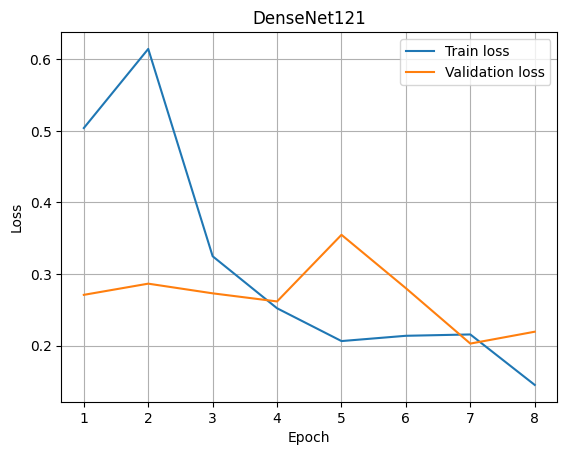

In [46]:
plot_loss_history(dn121_train_losses, dn121_val_losses, title='DenseNet121')

In [51]:
densenet.load_state_dict(torch.load('/kaggle/working/DenseNet121_best_result.pt'))

<All keys matched successfully>

In [49]:
# torch.save(densenet.state_dict(), '/kaggle/working/densenet121_full_data.pt')

In [208]:
# torch.save(densenet.state_dict(), '/kaggle/working/densenet_mini_data_with_hagrid.pt')

In [39]:
# torch.save(densenet.state_dict(), '/kaggle/working/densenet_mini_data.pt')

In [84]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
all_labels = np.array([])
all_preds = np.array([])
densenet.eval()
for data in tqdm(testloader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    # calculate outputs by running images through the network
#         print(images.shape)
    outputs = F.softmax(densenet(images), dim=-1)
#         print(densenet(images).shape)
    # the class with the highest energy is what we choose as prediction
#         print(outputs.data)
#         break
    _, predicted = torch.max(outputs.data, dim=-1)
#         print(predicted.cpu().numpy())
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    all_labels = np.append(all_labels, labels.cpu().numpy())
    all_preds = np.append(all_preds, predicted.cpu().numpy())

100%|██████████| 327/327 [04:53<00:00,  1.11it/s]


In [85]:
all_preds = all_preds.astype(int)
all_labels = all_labels.astype(int)

In [86]:
all_preds[all_preds == 6] = 1
all_labels[all_labels == 6] = 1

In [87]:
dict(zip(sorted(data_copy['class'].unique()), le.inverse_transform(sorted(data_copy['class'].unique()))))

{0: 'Hand_cellular',
 1: 'Hand_cigarette',
 2: 'Hand_empty',
 3: 'Hand_over_wheel',
 4: 'Hand_under_wheel',
 5: 'Hand_unknown',
 6: 'Hand_vape',
 7: 'Not_hand'}

In [88]:
np.unique(all_preds)

array([0, 1, 2, 3, 4, 5, 7])

In [89]:
unique, counts = np.unique(all_preds, return_counts=True)
dict(zip(unique, counts))

{0: 1478, 1: 491, 2: 1118, 3: 574, 4: 1083, 5: 2643, 7: 3050}

## Подсчет метрик отдельно по классам

In [91]:
target_names = le.inverse_transform(np.unique(all_preds))
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

                  precision    recall  f1-score   support

   Hand_cellular     0.9364    0.9886    0.9618      1400
  Hand_cigarette     0.8961    0.9670    0.9302       455
      Hand_empty     0.9258    0.9119    0.9188      1135
 Hand_over_wheel     0.8310    0.9086    0.8681       525
Hand_under_wheel     0.9797    0.9628    0.9712      1102
    Hand_unknown     0.9701    0.9025    0.9351      2841
        Not_hand     0.9695    0.9926    0.9809      2979

        accuracy                         0.9503     10437
       macro avg     0.9298    0.9477    0.9380     10437
    weighted avg     0.9514    0.9503    0.9502     10437



In [72]:
target_names

array(['Hand_cellular', 'Hand_cigarette', 'Hand_empty', 'Hand_over_wheel',
       'Hand_under_wheel', 'Hand_unknown', 'Not_hand'], dtype=object)

<Figure size 2000x400 with 0 Axes>

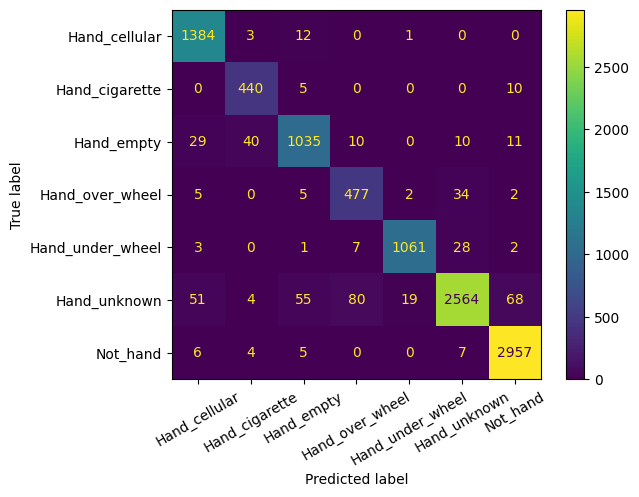

In [92]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)
disp.plot()
plt.xticks(rotation=30)
plt.show()

In [74]:
def predict_one_random_image(net, data):
    net.eval()
    dataset_no_transform = DriverHandsDataset(data, ROOT_DIR)
    random_index = random.randint(0, len(dataset_no_transform) - 1) 
  
    plt.imshow(dataset_no_transform[random_index][0])
    true_label = le.inverse_transform([dataset_no_transform[random_index][1].item()])[0]
    
    inp_image = torch.unsqueeze(transform(dataset_no_transform[random_index][0]), dim=0)

    probs = F.softmax(net.cpu()(inp_image), dim=-1)
    
    _, predicted = torch.max(probs.data, dim=-1)
    pred_label = le.inverse_transform([predicted.item()])[0]
    
    plt.title(f'gt: {true_label}, pred: {pred_label}')
    
    plt.show()

In [75]:
# torch.cuda.empty_cache()

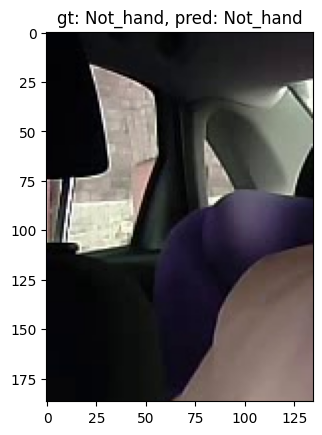

In [82]:
predict_one_random_image(densenet, data_copy)

## Проверка предсказаний модели на кадрах, где нет рук

In [83]:
len(empty_images_paths)

25567

In [36]:
class NoHandsDataset(Dataset):
    def __init__(self, paths: list, root_dir, transform=None):
        self.paths = paths
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.paths[index])
        # image = io.imread(img_path)
        image = Image.open(img_path)
        frame_width, frame_height = image.size
        
        crop_height = random.randint(120, 200)
        crop_width = random.randint(120, 200)
        
        x = random.randint(0, frame_width - crop_width)
        y = random.randint(0, frame_height - crop_height)
        
        crop_area = (x, y, x + crop_width, y + crop_height)
        image = image.crop(crop_area)
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [204]:
no_hands_dataset_no_transform = NoHandsDataset(empty_images_paths[:5000], ROOT_DIR)

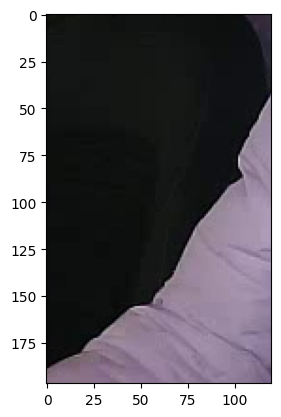

In [205]:
random_index = random.randint(0, len(no_hands_dataset_no_transform) - 1) 
  
# Plotting the randomly selected image 
plt.imshow(no_hands_dataset_no_transform[random_index])
plt.show()

In [206]:
no_hands_dataset = NoHandsDataset(empty_images_paths, ROOT_DIR, transform=transform)

In [207]:
no_hands_loader = DataLoader(no_hands_dataset, batch_size=32,
                                          shuffle=True)

In [46]:
no_hands_preds = np.array([])
densenet = densenet.to(device)
densenet.eval()
for data in tqdm(no_hands_loader):
    images = data
    images = images.to(device)
    # calculate outputs by running images through the network
#         print(images.shape)
    outputs = F.softmax(densenet(images), dim=-1)
#         print(densenet(images).shape)
    # the class with the highest energy is what we choose as prediction
#         print(outputs.data)
#         break
    _, predicted = torch.max(outputs.data, dim=-1)
#         print(predicted.cpu().numpy())

    no_hands_preds = np.append(no_hands_preds, predicted.cpu().numpy())

100%|██████████| 799/799 [09:05<00:00,  1.47it/s]


In [47]:
len(no_hands_preds)

25544

In [48]:
unique, counts = np.unique(no_hands_preds, return_counts=True)

In [49]:
unique = le.inverse_transform(unique.astype(int))

### Количество предсказаний по классам на кадрах без рук

In [50]:
dict(zip(unique, counts))

{'Hand_cellular': 3,
 'Hand_empty': 35,
 'Hand_food': 28,
 'Hand_over_wheel': 3,
 'Hand_unknown': 55,
 'Not_hand': 25420}

# Обучение MobileNetV2

In [54]:
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
mobilenet.classifier[1] = nn.Linear(1280, n_classes, bias=True)
mobilenet = mobilenet.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [39]:
# mobilenet.load_state_dict(torch.load('/kaggle/working/mobilenet_full_data.pt'))

<All keys matched successfully>

In [40]:
# mobilenet.load_state_dict(torch.load('/kaggle/working/mobilenet_mini_data_with_hagrid.pt'))

<All keys matched successfully>

In [55]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).to(device))
optimizer = optim.SGD(mobilenet.parameters(), lr=0.001, momentum=0.9)

In [56]:
mn_train_losses, mn_val_losses = train(mobilenet, criterion, optimizer, model_name='MobileNetV2', n_epochs=8)

  3%|▎         | 20/647 [00:11<06:13,  1.68it/s]

[1,    20] loss: 1.763


  6%|▌         | 40/647 [00:22<05:28,  1.85it/s]

[1,    40] loss: 1.483


  9%|▉         | 60/647 [00:34<05:29,  1.78it/s]

[1,    60] loss: 0.864


 12%|█▏        | 80/647 [00:45<05:16,  1.79it/s]

[1,    80] loss: 0.691


 15%|█▌        | 100/647 [00:56<05:01,  1.82it/s]

[1,   100] loss: 0.585


 19%|█▊        | 120/647 [01:07<04:44,  1.85it/s]

[1,   120] loss: 0.678


 22%|██▏       | 140/647 [01:19<05:07,  1.65it/s]

[1,   140] loss: 0.594


 25%|██▍       | 160/647 [01:30<04:24,  1.84it/s]

[1,   160] loss: 0.540


 28%|██▊       | 180/647 [01:42<04:32,  1.71it/s]

[1,   180] loss: 0.510


 31%|███       | 200/647 [01:53<04:13,  1.76it/s]

[1,   200] loss: 0.532


 34%|███▍      | 220/647 [02:05<03:56,  1.80it/s]

[1,   220] loss: 0.510


 37%|███▋      | 240/647 [02:16<03:53,  1.74it/s]

[1,   240] loss: 0.532


 40%|████      | 260/647 [02:27<03:43,  1.73it/s]

[1,   260] loss: 0.633


 43%|████▎     | 280/647 [02:38<03:39,  1.67it/s]

[1,   280] loss: 0.499


 46%|████▋     | 300/647 [02:50<03:14,  1.79it/s]

[1,   300] loss: 0.454


 49%|████▉     | 320/647 [03:01<03:07,  1.74it/s]

[1,   320] loss: 0.426


 53%|█████▎    | 340/647 [03:12<02:47,  1.83it/s]

[1,   340] loss: 0.446


 56%|█████▌    | 360/647 [03:23<02:45,  1.74it/s]

[1,   360] loss: 0.333


 59%|█████▊    | 380/647 [03:35<02:30,  1.77it/s]

[1,   380] loss: 0.446


 62%|██████▏   | 400/647 [03:47<02:32,  1.62it/s]

[1,   400] loss: 0.304


 65%|██████▍   | 420/647 [03:59<02:12,  1.72it/s]

[1,   420] loss: 0.305


 68%|██████▊   | 440/647 [04:11<01:56,  1.78it/s]

[1,   440] loss: 0.300


 71%|███████   | 460/647 [04:22<01:47,  1.73it/s]

[1,   460] loss: 0.306


 74%|███████▍  | 480/647 [04:34<01:31,  1.82it/s]

[1,   480] loss: 0.395


 77%|███████▋  | 500/647 [04:45<01:25,  1.73it/s]

[1,   500] loss: 0.354


 80%|████████  | 520/647 [04:57<01:12,  1.76it/s]

[1,   520] loss: 0.324


 83%|████████▎ | 540/647 [05:08<01:03,  1.69it/s]

[1,   540] loss: 0.402


 87%|████████▋ | 560/647 [05:20<00:50,  1.73it/s]

[1,   560] loss: 0.492


 90%|████████▉ | 580/647 [05:32<00:37,  1.76it/s]

[1,   580] loss: 0.432


 93%|█████████▎| 600/647 [05:43<00:26,  1.77it/s]

[1,   600] loss: 0.342


 96%|█████████▌| 620/647 [05:54<00:15,  1.70it/s]

[1,   620] loss: 0.328


 99%|█████████▉| 640/647 [06:06<00:04,  1.73it/s]

[1,   640] loss: 0.364


100%|██████████| 115/115 [00:59<00:00,  1.94it/s]


[1] val loss: 0.3013667988388435
Saving model...


  3%|▎         | 20/647 [00:10<05:22,  1.94it/s]

[2,    20] loss: 0.977


  6%|▌         | 40/647 [00:21<05:34,  1.82it/s]

[2,    40] loss: 1.918


  9%|▉         | 60/647 [00:32<05:06,  1.92it/s]

[2,    60] loss: 2.077


 12%|█▏        | 80/647 [00:43<05:11,  1.82it/s]

[2,    80] loss: 2.052


 15%|█▌        | 100/647 [00:54<04:57,  1.84it/s]

[2,   100] loss: 1.980


 19%|█▊        | 120/647 [01:04<04:23,  2.00it/s]

[2,   120] loss: 1.947


 22%|██▏       | 140/647 [01:15<04:21,  1.94it/s]

[2,   140] loss: 1.587


 25%|██▍       | 160/647 [01:26<04:21,  1.86it/s]

[2,   160] loss: 1.541


 28%|██▊       | 180/647 [01:36<04:06,  1.89it/s]

[2,   180] loss: 1.314


 31%|███       | 200/647 [01:47<03:52,  1.93it/s]

[2,   200] loss: 1.005


 34%|███▍      | 220/647 [01:58<03:59,  1.78it/s]

[2,   220] loss: 1.044


 37%|███▋      | 240/647 [02:08<03:46,  1.79it/s]

[2,   240] loss: 1.020


 40%|████      | 260/647 [02:19<03:28,  1.86it/s]

[2,   260] loss: 0.924


 43%|████▎     | 280/647 [02:30<03:23,  1.80it/s]

[2,   280] loss: 0.806


 46%|████▋     | 300/647 [02:41<03:08,  1.84it/s]

[2,   300] loss: 0.721


 49%|████▉     | 320/647 [02:52<02:44,  1.99it/s]

[2,   320] loss: 0.592


 53%|█████▎    | 340/647 [03:03<02:44,  1.87it/s]

[2,   340] loss: 0.673


 56%|█████▌    | 360/647 [03:14<02:30,  1.91it/s]

[2,   360] loss: 0.685


 59%|█████▊    | 380/647 [03:25<02:34,  1.73it/s]

[2,   380] loss: 0.681


 62%|██████▏   | 400/647 [03:36<02:10,  1.89it/s]

[2,   400] loss: 0.794


 65%|██████▍   | 420/647 [03:47<02:02,  1.85it/s]

[2,   420] loss: 0.742


 68%|██████▊   | 440/647 [03:58<01:58,  1.74it/s]

[2,   440] loss: 0.358


 71%|███████   | 460/647 [04:09<01:48,  1.73it/s]

[2,   460] loss: 0.555


 74%|███████▍  | 480/647 [04:20<01:28,  1.88it/s]

[2,   480] loss: 0.656


 77%|███████▋  | 500/647 [04:31<01:20,  1.82it/s]

[2,   500] loss: 0.454


 80%|████████  | 520/647 [04:42<01:07,  1.87it/s]

[2,   520] loss: 0.609


 83%|████████▎ | 540/647 [04:53<00:58,  1.84it/s]

[2,   540] loss: 0.550


 87%|████████▋ | 560/647 [05:04<00:46,  1.86it/s]

[2,   560] loss: 0.433


 90%|████████▉ | 580/647 [05:15<00:37,  1.78it/s]

[2,   580] loss: 0.450


 93%|█████████▎| 600/647 [05:26<00:26,  1.78it/s]

[2,   600] loss: 0.766


 96%|█████████▌| 620/647 [05:37<00:15,  1.78it/s]

[2,   620] loss: 0.648


 99%|█████████▉| 640/647 [05:48<00:03,  1.86it/s]

[2,   640] loss: 0.566


100%|██████████| 115/115 [00:55<00:00,  2.07it/s]


[2] val loss: 0.5286027584386909


  3%|▎         | 20/647 [00:10<05:42,  1.83it/s]

[3,    20] loss: 0.461


  6%|▌         | 40/647 [00:21<05:28,  1.85it/s]

[3,    40] loss: 0.596


  9%|▉         | 60/647 [00:31<05:19,  1.84it/s]

[3,    60] loss: 0.455


 12%|█▏        | 80/647 [00:42<05:06,  1.85it/s]

[3,    80] loss: 0.543


 15%|█▌        | 100/647 [00:53<04:55,  1.85it/s]

[3,   100] loss: 0.493


 19%|█▊        | 120/647 [01:04<04:26,  1.98it/s]

[3,   120] loss: 0.517


 22%|██▏       | 140/647 [01:14<04:21,  1.94it/s]

[3,   140] loss: 0.422


 25%|██▍       | 160/647 [01:25<04:15,  1.90it/s]

[3,   160] loss: 0.619


 28%|██▊       | 180/647 [01:36<04:09,  1.87it/s]

[3,   180] loss: 0.372


 31%|███       | 200/647 [01:46<03:54,  1.91it/s]

[3,   200] loss: 0.423


 34%|███▍      | 220/647 [01:57<03:49,  1.86it/s]

[3,   220] loss: 0.385


 37%|███▋      | 240/647 [02:08<03:38,  1.87it/s]

[3,   240] loss: 0.566


 40%|████      | 260/647 [02:18<03:28,  1.86it/s]

[3,   260] loss: 0.348


 43%|████▎     | 280/647 [02:29<03:14,  1.89it/s]

[3,   280] loss: 0.346


 46%|████▋     | 300/647 [02:40<03:00,  1.92it/s]

[3,   300] loss: 0.393


 49%|████▉     | 320/647 [02:50<02:46,  1.97it/s]

[3,   320] loss: 0.472


 53%|█████▎    | 340/647 [03:01<02:47,  1.83it/s]

[3,   340] loss: 0.432


 56%|█████▌    | 360/647 [03:11<02:36,  1.83it/s]

[3,   360] loss: 0.482


 59%|█████▊    | 380/647 [03:22<02:22,  1.87it/s]

[3,   380] loss: 0.488


 62%|██████▏   | 400/647 [03:33<02:11,  1.88it/s]

[3,   400] loss: 0.403


 65%|██████▍   | 420/647 [03:44<02:08,  1.76it/s]

[3,   420] loss: 0.459


 68%|██████▊   | 440/647 [03:55<01:53,  1.83it/s]

[3,   440] loss: 0.390


 71%|███████   | 460/647 [04:07<01:42,  1.82it/s]

[3,   460] loss: 0.349


 74%|███████▍  | 480/647 [04:17<01:30,  1.86it/s]

[3,   480] loss: 0.313


 77%|███████▋  | 500/647 [04:28<01:23,  1.77it/s]

[3,   500] loss: 0.491


 80%|████████  | 520/647 [04:39<01:08,  1.85it/s]

[3,   520] loss: 0.416


 83%|████████▎ | 540/647 [04:50<00:59,  1.80it/s]

[3,   540] loss: 0.432


 87%|████████▋ | 560/647 [05:01<00:46,  1.87it/s]

[3,   560] loss: 0.326


 90%|████████▉ | 580/647 [05:12<00:36,  1.85it/s]

[3,   580] loss: 0.316


 93%|█████████▎| 600/647 [05:23<00:25,  1.88it/s]

[3,   600] loss: 0.284


 96%|█████████▌| 620/647 [05:34<00:14,  1.83it/s]

[3,   620] loss: 0.317


 99%|█████████▉| 640/647 [05:45<00:03,  1.77it/s]

[3,   640] loss: 0.411


100%|██████████| 115/115 [00:54<00:00,  2.13it/s]


[3] val loss: 0.32223690800044846


  3%|▎         | 20/647 [00:10<05:27,  1.91it/s]

[4,    20] loss: 0.274


  6%|▌         | 40/647 [00:21<05:27,  1.86it/s]

[4,    40] loss: 0.328


  9%|▉         | 60/647 [00:32<05:15,  1.86it/s]

[4,    60] loss: 0.312


 12%|█▏        | 80/647 [00:43<05:18,  1.78it/s]

[4,    80] loss: 0.293


 15%|█▌        | 100/647 [00:54<05:02,  1.81it/s]

[4,   100] loss: 0.367


 19%|█▊        | 120/647 [01:05<04:45,  1.84it/s]

[4,   120] loss: 0.429


 22%|██▏       | 140/647 [01:16<04:26,  1.90it/s]

[4,   140] loss: 0.396


 25%|██▍       | 160/647 [01:27<04:44,  1.71it/s]

[4,   160] loss: 0.344


 28%|██▊       | 180/647 [01:38<04:26,  1.75it/s]

[4,   180] loss: 0.287


 31%|███       | 200/647 [01:49<04:07,  1.81it/s]

[4,   200] loss: 0.689


 34%|███▍      | 220/647 [02:01<03:57,  1.80it/s]

[4,   220] loss: 0.398


 37%|███▋      | 240/647 [02:12<03:45,  1.81it/s]

[4,   240] loss: 0.419


 40%|████      | 260/647 [02:23<03:37,  1.78it/s]

[4,   260] loss: 0.356


 43%|████▎     | 280/647 [02:34<03:27,  1.77it/s]

[4,   280] loss: 0.385


 46%|████▋     | 300/647 [02:45<03:09,  1.83it/s]

[4,   300] loss: 0.219


 49%|████▉     | 320/647 [02:56<03:06,  1.76it/s]

[4,   320] loss: 0.390


 53%|█████▎    | 340/647 [03:07<02:45,  1.85it/s]

[4,   340] loss: 0.284


 56%|█████▌    | 360/647 [03:18<02:42,  1.77it/s]

[4,   360] loss: 0.407


 59%|█████▊    | 380/647 [03:29<02:38,  1.69it/s]

[4,   380] loss: 0.394


 62%|██████▏   | 400/647 [03:40<02:15,  1.83it/s]

[4,   400] loss: 0.331


 65%|██████▍   | 420/647 [03:51<02:02,  1.86it/s]

[4,   420] loss: 0.219


 68%|██████▊   | 440/647 [04:03<02:00,  1.72it/s]

[4,   440] loss: 0.458


 71%|███████   | 460/647 [04:14<01:46,  1.76it/s]

[4,   460] loss: 0.500


 74%|███████▍  | 480/647 [04:25<01:30,  1.84it/s]

[4,   480] loss: 0.328


 77%|███████▋  | 500/647 [04:36<01:20,  1.82it/s]

[4,   500] loss: 0.248


 80%|████████  | 520/647 [04:46<01:12,  1.76it/s]

[4,   520] loss: 0.311


 83%|████████▎ | 540/647 [04:58<00:57,  1.85it/s]

[4,   540] loss: 0.223


 87%|████████▋ | 560/647 [05:09<00:47,  1.84it/s]

[4,   560] loss: 0.276


 90%|████████▉ | 580/647 [05:20<00:35,  1.87it/s]

[4,   580] loss: 0.461


 93%|█████████▎| 600/647 [05:31<00:27,  1.72it/s]

[4,   600] loss: 0.425


 96%|█████████▌| 620/647 [05:42<00:14,  1.84it/s]

[4,   620] loss: 0.255


 99%|█████████▉| 640/647 [05:54<00:03,  1.80it/s]

[4,   640] loss: 0.283


100%|██████████| 115/115 [00:54<00:00,  2.10it/s]


[4] val loss: 0.40308204131281894


  3%|▎         | 20/647 [00:10<05:26,  1.92it/s]

[5,    20] loss: 0.318


  6%|▌         | 40/647 [00:21<05:32,  1.82it/s]

[5,    40] loss: 0.242


  9%|▉         | 60/647 [00:32<05:18,  1.84it/s]

[5,    60] loss: 0.232


 12%|█▏        | 80/647 [00:43<05:16,  1.79it/s]

[5,    80] loss: 0.171


 15%|█▌        | 100/647 [00:53<04:48,  1.90it/s]

[5,   100] loss: 0.375


 19%|█▊        | 120/647 [01:04<04:37,  1.90it/s]

[5,   120] loss: 0.360


 22%|██▏       | 140/647 [01:14<04:49,  1.75it/s]

[5,   140] loss: 0.272


 25%|██▍       | 160/647 [01:25<04:29,  1.81it/s]

[5,   160] loss: 0.361


 28%|██▊       | 180/647 [01:36<04:12,  1.85it/s]

[5,   180] loss: 0.796


 31%|███       | 200/647 [01:47<04:09,  1.79it/s]

[5,   200] loss: 0.472


 34%|███▍      | 220/647 [01:58<04:03,  1.75it/s]

[5,   220] loss: 0.250


 37%|███▋      | 240/647 [02:08<03:27,  1.96it/s]

[5,   240] loss: 0.268


 40%|████      | 260/647 [02:19<03:34,  1.80it/s]

[5,   260] loss: 0.242


 43%|████▎     | 280/647 [02:30<03:17,  1.86it/s]

[5,   280] loss: 0.254


 46%|████▋     | 300/647 [02:41<03:07,  1.85it/s]

[5,   300] loss: 0.278


 49%|████▉     | 320/647 [02:52<02:57,  1.84it/s]

[5,   320] loss: 0.278


 53%|█████▎    | 340/647 [03:03<02:48,  1.83it/s]

[5,   340] loss: 0.399


 56%|█████▌    | 360/647 [03:14<02:40,  1.79it/s]

[5,   360] loss: 0.361


 59%|█████▊    | 380/647 [03:24<02:19,  1.91it/s]

[5,   380] loss: 0.348


 62%|██████▏   | 400/647 [03:35<02:15,  1.82it/s]

[5,   400] loss: 0.229


 65%|██████▍   | 420/647 [03:46<02:02,  1.85it/s]

[5,   420] loss: 0.296


 68%|██████▊   | 440/647 [03:57<01:51,  1.85it/s]

[5,   440] loss: 0.255


 71%|███████   | 460/647 [04:08<01:39,  1.89it/s]

[5,   460] loss: 0.260


 74%|███████▍  | 480/647 [04:19<01:33,  1.78it/s]

[5,   480] loss: 0.452


 77%|███████▋  | 500/647 [04:29<01:19,  1.84it/s]

[5,   500] loss: 0.257


 80%|████████  | 520/647 [04:40<01:08,  1.86it/s]

[5,   520] loss: 0.325


 83%|████████▎ | 540/647 [04:51<00:57,  1.86it/s]

[5,   540] loss: 0.299


 87%|████████▋ | 560/647 [05:02<00:48,  1.81it/s]

[5,   560] loss: 0.432


 90%|████████▉ | 580/647 [05:13<00:37,  1.81it/s]

[5,   580] loss: 0.314


 93%|█████████▎| 600/647 [05:25<00:29,  1.59it/s]

[5,   600] loss: 0.263


 96%|█████████▌| 620/647 [05:36<00:15,  1.76it/s]

[5,   620] loss: 0.146


 99%|█████████▉| 640/647 [05:48<00:04,  1.73it/s]

[5,   640] loss: 0.263


100%|██████████| 115/115 [00:56<00:00,  2.03it/s]


[5] val loss: 0.2931196594691795
Saving model...


  3%|▎         | 20/647 [00:10<05:32,  1.89it/s]

[6,    20] loss: 0.325


  6%|▌         | 40/647 [00:21<05:14,  1.93it/s]

[6,    40] loss: 0.383


  9%|▉         | 60/647 [00:31<05:19,  1.84it/s]

[6,    60] loss: 0.290


 12%|█▏        | 80/647 [00:42<04:54,  1.93it/s]

[6,    80] loss: 0.243


 15%|█▌        | 100/647 [00:52<04:33,  2.00it/s]

[6,   100] loss: 0.165


 19%|█▊        | 120/647 [01:02<04:26,  1.97it/s]

[6,   120] loss: 0.290


 22%|██▏       | 140/647 [01:13<04:39,  1.81it/s]

[6,   140] loss: 0.288


 25%|██▍       | 160/647 [01:24<04:24,  1.84it/s]

[6,   160] loss: 0.322


 28%|██▊       | 180/647 [01:34<04:10,  1.86it/s]

[6,   180] loss: 0.199


 31%|███       | 200/647 [01:45<03:59,  1.87it/s]

[6,   200] loss: 0.147


 34%|███▍      | 220/647 [01:56<03:53,  1.83it/s]

[6,   220] loss: 0.294


 37%|███▋      | 240/647 [02:07<03:37,  1.87it/s]

[6,   240] loss: 0.187


 40%|████      | 260/647 [02:18<03:28,  1.85it/s]

[6,   260] loss: 0.213


 43%|████▎     | 280/647 [02:29<03:11,  1.91it/s]

[6,   280] loss: 0.310


 46%|████▋     | 300/647 [02:39<03:05,  1.87it/s]

[6,   300] loss: 0.287


 49%|████▉     | 320/647 [02:50<02:55,  1.86it/s]

[6,   320] loss: 0.258


 53%|█████▎    | 340/647 [03:01<02:41,  1.90it/s]

[6,   340] loss: 0.201


 56%|█████▌    | 360/647 [03:11<02:34,  1.85it/s]

[6,   360] loss: 0.192


 59%|█████▊    | 380/647 [03:23<02:32,  1.75it/s]

[6,   380] loss: 0.280


 62%|██████▏   | 400/647 [03:33<02:16,  1.81it/s]

[6,   400] loss: 0.230


 65%|██████▍   | 420/647 [03:44<02:10,  1.74it/s]

[6,   420] loss: 0.156


 68%|██████▊   | 440/647 [03:56<01:56,  1.78it/s]

[6,   440] loss: 0.220


 71%|███████   | 460/647 [04:07<01:49,  1.71it/s]

[6,   460] loss: 0.222


 74%|███████▍  | 480/647 [04:18<01:35,  1.75it/s]

[6,   480] loss: 0.354


 77%|███████▋  | 500/647 [04:29<01:17,  1.89it/s]

[6,   500] loss: 0.295


 80%|████████  | 520/647 [04:39<01:09,  1.82it/s]

[6,   520] loss: 0.313


 83%|████████▎ | 540/647 [04:51<01:00,  1.78it/s]

[6,   540] loss: 0.275


 87%|████████▋ | 560/647 [05:01<00:46,  1.86it/s]

[6,   560] loss: 0.202


 90%|████████▉ | 580/647 [05:12<00:37,  1.81it/s]

[6,   580] loss: 0.199


 93%|█████████▎| 600/647 [05:24<00:27,  1.71it/s]

[6,   600] loss: 0.200


 96%|█████████▌| 620/647 [05:34<00:14,  1.92it/s]

[6,   620] loss: 0.295


 99%|█████████▉| 640/647 [05:46<00:03,  1.84it/s]

[6,   640] loss: 0.227


100%|██████████| 115/115 [00:55<00:00,  2.06it/s]


[6] val loss: 0.24974835160309855
Saving model...


  3%|▎         | 20/647 [00:11<06:01,  1.73it/s]

[7,    20] loss: 0.139


  6%|▌         | 40/647 [00:22<05:30,  1.84it/s]

[7,    40] loss: 0.179


  9%|▉         | 60/647 [00:32<05:26,  1.80it/s]

[7,    60] loss: 0.213


 12%|█▏        | 80/647 [00:43<04:53,  1.93it/s]

[7,    80] loss: 0.179


 15%|█▌        | 100/647 [00:54<04:52,  1.87it/s]

[7,   100] loss: 0.296


 19%|█▊        | 120/647 [01:04<04:38,  1.89it/s]

[7,   120] loss: 0.161


 22%|██▏       | 140/647 [01:16<04:40,  1.81it/s]

[7,   140] loss: 0.233


 25%|██▍       | 160/647 [01:27<04:37,  1.76it/s]

[7,   160] loss: 0.367


 28%|██▊       | 180/647 [01:37<04:16,  1.82it/s]

[7,   180] loss: 0.365


 31%|███       | 200/647 [01:48<04:04,  1.83it/s]

[7,   200] loss: 0.221


 34%|███▍      | 220/647 [01:59<03:44,  1.90it/s]

[7,   220] loss: 0.167


 37%|███▋      | 240/647 [02:10<03:31,  1.93it/s]

[7,   240] loss: 0.176


 40%|████      | 260/647 [02:21<03:41,  1.75it/s]

[7,   260] loss: 0.318


 43%|████▎     | 280/647 [02:32<03:21,  1.82it/s]

[7,   280] loss: 0.283


 46%|████▋     | 300/647 [02:43<03:09,  1.83it/s]

[7,   300] loss: 0.314


 49%|████▉     | 320/647 [02:54<03:01,  1.80it/s]

[7,   320] loss: 0.268


 53%|█████▎    | 340/647 [03:05<02:43,  1.88it/s]

[7,   340] loss: 0.262


 56%|█████▌    | 360/647 [03:16<02:39,  1.80it/s]

[7,   360] loss: 0.263


 59%|█████▊    | 380/647 [03:26<02:21,  1.88it/s]

[7,   380] loss: 0.230


 62%|██████▏   | 400/647 [03:37<02:12,  1.86it/s]

[7,   400] loss: 0.318


 65%|██████▍   | 420/647 [03:48<02:10,  1.74it/s]

[7,   420] loss: 0.360


 68%|██████▊   | 440/647 [03:59<01:55,  1.80it/s]

[7,   440] loss: 0.286


 71%|███████   | 460/647 [04:10<01:48,  1.72it/s]

[7,   460] loss: 0.167


 74%|███████▍  | 480/647 [04:22<01:32,  1.80it/s]

[7,   480] loss: 0.187


 77%|███████▋  | 500/647 [04:33<01:22,  1.79it/s]

[7,   500] loss: 0.220


 80%|████████  | 520/647 [04:44<01:11,  1.79it/s]

[7,   520] loss: 0.256


 83%|████████▎ | 540/647 [04:55<00:59,  1.80it/s]

[7,   540] loss: 0.267


 87%|████████▋ | 560/647 [05:06<00:46,  1.88it/s]

[7,   560] loss: 0.131


 90%|████████▉ | 580/647 [05:17<00:38,  1.76it/s]

[7,   580] loss: 0.179


 93%|█████████▎| 600/647 [05:28<00:25,  1.81it/s]

[7,   600] loss: 0.244


 96%|█████████▌| 620/647 [05:39<00:15,  1.75it/s]

[7,   620] loss: 0.153


 99%|█████████▉| 640/647 [05:51<00:03,  1.86it/s]

[7,   640] loss: 0.229


100%|██████████| 115/115 [00:53<00:00,  2.14it/s]


[7] val loss: 0.27369088397725766


  3%|▎         | 20/647 [00:10<05:39,  1.85it/s]

[8,    20] loss: 0.177


  6%|▌         | 40/647 [00:21<05:11,  1.95it/s]

[8,    40] loss: 0.207


  9%|▉         | 60/647 [00:31<05:06,  1.91it/s]

[8,    60] loss: 0.204


 12%|█▏        | 80/647 [00:41<04:55,  1.92it/s]

[8,    80] loss: 0.220


 15%|█▌        | 100/647 [00:52<04:43,  1.93it/s]

[8,   100] loss: 0.254


 19%|█▊        | 120/647 [01:02<04:35,  1.91it/s]

[8,   120] loss: 0.370


 22%|██▏       | 140/647 [01:13<04:46,  1.77it/s]

[8,   140] loss: 0.281


 25%|██▍       | 160/647 [01:24<04:13,  1.92it/s]

[8,   160] loss: 0.203


 28%|██▊       | 180/647 [01:34<04:19,  1.80it/s]

[8,   180] loss: 0.187


 31%|███       | 200/647 [01:46<04:00,  1.86it/s]

[8,   200] loss: 0.304


 34%|███▍      | 220/647 [01:56<03:47,  1.88it/s]

[8,   220] loss: 0.298


 37%|███▋      | 240/647 [02:07<03:40,  1.85it/s]

[8,   240] loss: 0.235


 40%|████      | 260/647 [02:18<03:24,  1.89it/s]

[8,   260] loss: 0.170


 43%|████▎     | 280/647 [02:28<03:17,  1.86it/s]

[8,   280] loss: 0.197


 46%|████▋     | 300/647 [02:39<03:10,  1.82it/s]

[8,   300] loss: 0.140


 49%|████▉     | 320/647 [02:50<03:17,  1.66it/s]

[8,   320] loss: 0.268


 53%|█████▎    | 340/647 [03:01<02:37,  1.95it/s]

[8,   340] loss: 0.224


 56%|█████▌    | 360/647 [03:12<02:32,  1.88it/s]

[8,   360] loss: 0.234


 59%|█████▊    | 380/647 [03:23<02:20,  1.90it/s]

[8,   380] loss: 0.183


 62%|██████▏   | 400/647 [03:33<02:10,  1.89it/s]

[8,   400] loss: 0.214


 65%|██████▍   | 420/647 [03:44<02:02,  1.86it/s]

[8,   420] loss: 0.202


 68%|██████▊   | 440/647 [03:55<01:53,  1.82it/s]

[8,   440] loss: 0.317


 71%|███████   | 460/647 [04:05<01:42,  1.83it/s]

[8,   460] loss: 0.200


 74%|███████▍  | 480/647 [04:16<01:29,  1.86it/s]

[8,   480] loss: 0.258


 77%|███████▋  | 500/647 [04:27<01:20,  1.83it/s]

[8,   500] loss: 0.158


 80%|████████  | 520/647 [04:38<01:09,  1.82it/s]

[8,   520] loss: 0.136


 83%|████████▎ | 540/647 [04:49<01:01,  1.73it/s]

[8,   540] loss: 0.124


 87%|████████▋ | 560/647 [05:00<00:45,  1.89it/s]

[8,   560] loss: 0.235


 90%|████████▉ | 580/647 [05:11<00:34,  1.93it/s]

[8,   580] loss: 0.203


 93%|█████████▎| 600/647 [05:22<00:26,  1.75it/s]

[8,   600] loss: 0.169


 96%|█████████▌| 620/647 [05:33<00:15,  1.75it/s]

[8,   620] loss: 0.194


 99%|█████████▉| 640/647 [05:44<00:04,  1.71it/s]

[8,   640] loss: 0.145


100%|██████████| 115/115 [00:56<00:00,  2.04it/s]

[8] val loss: 0.3478442578455028
Finished Training


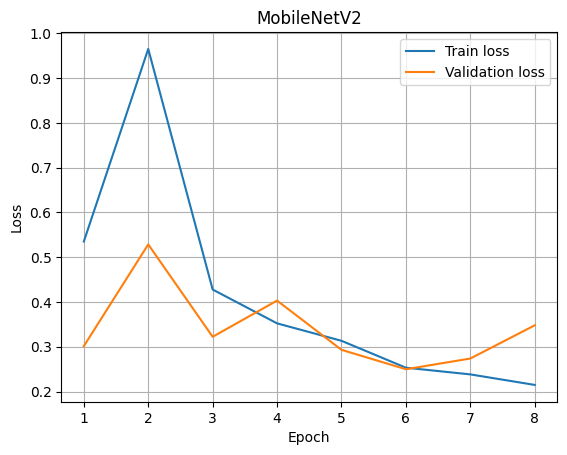

In [60]:
plot_loss_history(mn_train_losses, mn_val_losses, title='MobileNetV2')

In [59]:
mobilenet.load_state_dict(torch.load('/kaggle/working/MobileNetV2_best_result.pt'))

<All keys matched successfully>

In [89]:
# torch.save(mobilenet.state_dict(), '/kaggle/working/mobilenet_full_data.pt')

# Обучение DenseNet201

In [42]:
densenet201 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
densenet201.classifier = nn.Linear(in_features=1920, out_features=n_classes, bias=True)
# densenet201.load_state_dict(torch.load('/kaggle/working/densenet201_mini_data_with_hagrid.pt'))
# densenet201.load_state_dict(torch.load('/kaggle/working/densenet201_full_data.pt'))
densenet201 = densenet201.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 95.2MB/s]


In [43]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).to(device))
optimizer = optim.SGD(densenet201.parameters(), lr=0.001, momentum=0.9)

In [44]:
dn201_train_losses, dn201_val_losses = train(densenet201, criterion, optimizer, model_name='DenseNet201', n_epochs=8)

  3%|▎         | 20/647 [00:14<07:35,  1.38it/s]

[1,    20] loss: 1.856


  6%|▌         | 40/647 [00:29<07:39,  1.32it/s]

[1,    40] loss: 1.396


  9%|▉         | 60/647 [00:44<07:01,  1.39it/s]

[1,    60] loss: 1.021


 12%|█▏        | 80/647 [00:59<07:05,  1.33it/s]

[1,    80] loss: 0.814


 15%|█▌        | 100/647 [01:14<06:39,  1.37it/s]

[1,   100] loss: 0.606


 19%|█▊        | 120/647 [01:29<06:35,  1.33it/s]

[1,   120] loss: 0.542


 22%|██▏       | 140/647 [01:44<06:19,  1.34it/s]

[1,   140] loss: 0.601


 25%|██▍       | 160/647 [01:59<06:01,  1.35it/s]

[1,   160] loss: 0.557


 28%|██▊       | 180/647 [02:14<05:42,  1.36it/s]

[1,   180] loss: 0.424


 31%|███       | 200/647 [02:28<05:35,  1.33it/s]

[1,   200] loss: 0.461


 34%|███▍      | 220/647 [02:43<05:11,  1.37it/s]

[1,   220] loss: 0.432


 37%|███▋      | 240/647 [02:58<04:59,  1.36it/s]

[1,   240] loss: 0.388


 40%|████      | 260/647 [03:13<04:42,  1.37it/s]

[1,   260] loss: 0.340


 43%|████▎     | 280/647 [03:27<04:26,  1.38it/s]

[1,   280] loss: 0.344


 46%|████▋     | 300/647 [03:42<04:19,  1.34it/s]

[1,   300] loss: 0.327


 49%|████▉     | 320/647 [03:57<04:02,  1.35it/s]

[1,   320] loss: 0.278


 53%|█████▎    | 340/647 [04:12<03:54,  1.31it/s]

[1,   340] loss: 0.309


 56%|█████▌    | 360/647 [04:27<03:32,  1.35it/s]

[1,   360] loss: 0.345


 59%|█████▊    | 380/647 [04:42<03:25,  1.30it/s]

[1,   380] loss: 0.405


 62%|██████▏   | 400/647 [04:57<03:04,  1.34it/s]

[1,   400] loss: 0.500


 65%|██████▍   | 420/647 [05:12<02:53,  1.31it/s]

[1,   420] loss: 0.301


 68%|██████▊   | 440/647 [05:27<02:35,  1.33it/s]

[1,   440] loss: 0.305


 71%|███████   | 460/647 [05:42<02:22,  1.32it/s]

[1,   460] loss: 0.247


 74%|███████▍  | 480/647 [05:56<02:00,  1.38it/s]

[1,   480] loss: 0.270


 77%|███████▋  | 500/647 [06:12<01:49,  1.34it/s]

[1,   500] loss: 0.328


 80%|████████  | 520/647 [06:27<01:36,  1.32it/s]

[1,   520] loss: 0.291


 83%|████████▎ | 540/647 [06:42<01:19,  1.34it/s]

[1,   540] loss: 0.419


 87%|████████▋ | 560/647 [06:57<01:05,  1.33it/s]

[1,   560] loss: 0.280


 90%|████████▉ | 580/647 [07:12<00:49,  1.35it/s]

[1,   580] loss: 0.208


 93%|█████████▎| 600/647 [07:27<00:34,  1.36it/s]

[1,   600] loss: 0.261


 96%|█████████▌| 620/647 [07:42<00:21,  1.23it/s]

[1,   620] loss: 0.334


 99%|█████████▉| 640/647 [07:57<00:05,  1.29it/s]

[1,   640] loss: 0.219


100%|██████████| 115/115 [01:03<00:00,  1.82it/s]


[1] val loss: 0.21142081720349581
Saving model...


  3%|▎         | 20/647 [00:14<08:11,  1.28it/s]

[2,    20] loss: 0.852


  6%|▌         | 40/647 [00:29<07:19,  1.38it/s]

[2,    40] loss: 0.978


  9%|▉         | 60/647 [00:44<07:21,  1.33it/s]

[2,    60] loss: 0.692


 12%|█▏        | 80/647 [00:58<06:41,  1.41it/s]

[2,    80] loss: 0.654


 15%|█▌        | 100/647 [01:13<06:40,  1.37it/s]

[2,   100] loss: 0.676


 19%|█▊        | 120/647 [01:27<06:20,  1.39it/s]

[2,   120] loss: 0.511


 22%|██▏       | 140/647 [01:42<06:06,  1.38it/s]

[2,   140] loss: 1.102


 25%|██▍       | 160/647 [01:57<06:02,  1.34it/s]

[2,   160] loss: 0.781


 28%|██▊       | 180/647 [02:11<05:40,  1.37it/s]

[2,   180] loss: 0.804


 31%|███       | 200/647 [02:26<05:27,  1.36it/s]

[2,   200] loss: 0.481


 34%|███▍      | 220/647 [02:40<05:09,  1.38it/s]

[2,   220] loss: 0.478


 37%|███▋      | 240/647 [02:55<04:51,  1.40it/s]

[2,   240] loss: 0.488


 40%|████      | 260/647 [03:09<04:43,  1.37it/s]

[2,   260] loss: 0.565


 43%|████▎     | 280/647 [03:24<04:46,  1.28it/s]

[2,   280] loss: 0.475


 46%|████▋     | 300/647 [03:39<04:11,  1.38it/s]

[2,   300] loss: 0.439


 49%|████▉     | 320/647 [03:54<04:08,  1.32it/s]

[2,   320] loss: 0.512


 53%|█████▎    | 340/647 [04:09<03:57,  1.29it/s]

[2,   340] loss: 0.382


 56%|█████▌    | 360/647 [04:24<03:39,  1.31it/s]

[2,   360] loss: 0.387


 59%|█████▊    | 380/647 [04:39<03:12,  1.39it/s]

[2,   380] loss: 0.394


 62%|██████▏   | 400/647 [04:53<02:59,  1.38it/s]

[2,   400] loss: 0.512


 65%|██████▍   | 420/647 [05:08<02:50,  1.33it/s]

[2,   420] loss: 0.303


 68%|██████▊   | 440/647 [05:23<02:35,  1.33it/s]

[2,   440] loss: 0.243


 71%|███████   | 460/647 [05:38<02:20,  1.34it/s]

[2,   460] loss: 0.484


 74%|███████▍  | 480/647 [05:53<02:08,  1.30it/s]

[2,   480] loss: 0.575


 77%|███████▋  | 500/647 [06:08<01:46,  1.38it/s]

[2,   500] loss: 0.311


 80%|████████  | 520/647 [06:23<01:33,  1.35it/s]

[2,   520] loss: 0.553


 83%|████████▎ | 540/647 [06:37<01:20,  1.32it/s]

[2,   540] loss: 0.360


 87%|████████▋ | 560/647 [06:53<01:06,  1.31it/s]

[2,   560] loss: 0.375


 90%|████████▉ | 580/647 [07:08<00:50,  1.32it/s]

[2,   580] loss: 0.384


 93%|█████████▎| 600/647 [07:23<00:35,  1.31it/s]

[2,   600] loss: 0.190


 96%|█████████▌| 620/647 [07:38<00:20,  1.32it/s]

[2,   620] loss: 0.454


 99%|█████████▉| 640/647 [07:53<00:05,  1.34it/s]

[2,   640] loss: 0.256


100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


[2] val loss: 0.6078480712745501


  3%|▎         | 20/647 [00:14<07:49,  1.34it/s]

[3,    20] loss: 0.604


  6%|▌         | 40/647 [00:29<07:26,  1.36it/s]

[3,    40] loss: 0.318


  9%|▉         | 60/647 [00:44<07:07,  1.37it/s]

[3,    60] loss: 0.266


 12%|█▏        | 80/647 [00:58<06:49,  1.38it/s]

[3,    80] loss: 0.369


 15%|█▌        | 100/647 [01:14<07:00,  1.30it/s]

[3,   100] loss: 0.406


 19%|█▊        | 120/647 [01:29<06:36,  1.33it/s]

[3,   120] loss: 0.355


 22%|██▏       | 140/647 [01:43<06:05,  1.39it/s]

[3,   140] loss: 0.310


 25%|██▍       | 160/647 [01:58<05:59,  1.35it/s]

[3,   160] loss: 0.365


 28%|██▊       | 180/647 [02:13<05:55,  1.31it/s]

[3,   180] loss: 0.242


 31%|███       | 200/647 [02:28<05:38,  1.32it/s]

[3,   200] loss: 0.242


 34%|███▍      | 220/647 [02:43<05:21,  1.33it/s]

[3,   220] loss: 0.381


 37%|███▋      | 240/647 [02:58<05:01,  1.35it/s]

[3,   240] loss: 0.244


 40%|████      | 260/647 [03:14<05:04,  1.27it/s]

[3,   260] loss: 0.187


 43%|████▎     | 280/647 [03:29<04:36,  1.33it/s]

[3,   280] loss: 0.377


 46%|████▋     | 300/647 [03:44<04:22,  1.32it/s]

[3,   300] loss: 0.238


 49%|████▉     | 320/647 [03:59<04:00,  1.36it/s]

[3,   320] loss: 0.268


 53%|█████▎    | 340/647 [04:14<04:00,  1.28it/s]

[3,   340] loss: 0.263


 56%|█████▌    | 360/647 [04:29<03:34,  1.34it/s]

[3,   360] loss: 0.397


 59%|█████▊    | 380/647 [04:44<03:31,  1.26it/s]

[3,   380] loss: 0.413


 62%|██████▏   | 400/647 [04:59<03:05,  1.33it/s]

[3,   400] loss: 0.240


 65%|██████▍   | 420/647 [05:15<03:01,  1.25it/s]

[3,   420] loss: 0.343


 68%|██████▊   | 440/647 [05:30<02:35,  1.33it/s]

[3,   440] loss: 0.314


 71%|███████   | 460/647 [05:45<02:22,  1.31it/s]

[3,   460] loss: 0.172


 74%|███████▍  | 480/647 [06:00<02:09,  1.29it/s]

[3,   480] loss: 0.328


 77%|███████▋  | 500/647 [06:16<01:53,  1.29it/s]

[3,   500] loss: 0.358


 80%|████████  | 520/647 [06:31<01:37,  1.31it/s]

[3,   520] loss: 0.273


 83%|████████▎ | 540/647 [06:47<01:25,  1.25it/s]

[3,   540] loss: 0.216


 87%|████████▋ | 560/647 [07:02<01:04,  1.34it/s]

[3,   560] loss: 0.276


 90%|████████▉ | 580/647 [07:17<00:50,  1.33it/s]

[3,   580] loss: 0.239


 93%|█████████▎| 600/647 [07:33<00:35,  1.33it/s]

[3,   600] loss: 0.216


 96%|█████████▌| 620/647 [07:48<00:20,  1.31it/s]

[3,   620] loss: 0.247


 99%|█████████▉| 640/647 [08:03<00:05,  1.28it/s]

[3,   640] loss: 0.314


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


[3] val loss: 0.3120985199758054


  3%|▎         | 20/647 [00:15<07:59,  1.31it/s]

[4,    20] loss: 0.211


  6%|▌         | 40/647 [00:30<07:33,  1.34it/s]

[4,    40] loss: 0.197


  9%|▉         | 60/647 [00:45<07:45,  1.26it/s]

[4,    60] loss: 0.112


 12%|█▏        | 80/647 [01:00<07:00,  1.35it/s]

[4,    80] loss: 0.135


 15%|█▌        | 100/647 [01:16<07:09,  1.27it/s]

[4,   100] loss: 0.277


 19%|█▊        | 120/647 [01:31<06:40,  1.31it/s]

[4,   120] loss: 0.202


 22%|██▏       | 140/647 [01:46<06:14,  1.35it/s]

[4,   140] loss: 0.385


 25%|██▍       | 160/647 [02:01<06:04,  1.33it/s]

[4,   160] loss: 0.311


 28%|██▊       | 180/647 [02:17<06:03,  1.29it/s]

[4,   180] loss: 0.138


 31%|███       | 200/647 [02:32<05:55,  1.26it/s]

[4,   200] loss: 0.200


 34%|███▍      | 220/647 [02:47<05:36,  1.27it/s]

[4,   220] loss: 0.360


 37%|███▋      | 240/647 [03:03<05:12,  1.30it/s]

[4,   240] loss: 0.263


 40%|████      | 260/647 [03:18<05:03,  1.28it/s]

[4,   260] loss: 0.229


 43%|████▎     | 280/647 [03:34<04:42,  1.30it/s]

[4,   280] loss: 0.429


 46%|████▋     | 300/647 [03:49<04:35,  1.26it/s]

[4,   300] loss: 0.207


 49%|████▉     | 320/647 [04:04<04:08,  1.31it/s]

[4,   320] loss: 0.195


 53%|█████▎    | 340/647 [04:20<04:03,  1.26it/s]

[4,   340] loss: 0.168


 56%|█████▌    | 360/647 [04:35<03:40,  1.30it/s]

[4,   360] loss: 0.210


 59%|█████▊    | 380/647 [04:51<03:34,  1.24it/s]

[4,   380] loss: 0.550


 62%|██████▏   | 400/647 [05:06<03:11,  1.29it/s]

[4,   400] loss: 0.498


 65%|██████▍   | 420/647 [05:21<02:51,  1.32it/s]

[4,   420] loss: 0.364


 68%|██████▊   | 440/647 [05:37<02:35,  1.33it/s]

[4,   440] loss: 0.300


 71%|███████   | 460/647 [05:52<02:20,  1.33it/s]

[4,   460] loss: 0.288


 74%|███████▍  | 480/647 [06:07<02:04,  1.34it/s]

[4,   480] loss: 0.257


 77%|███████▋  | 500/647 [06:22<01:48,  1.35it/s]

[4,   500] loss: 0.314


 80%|████████  | 520/647 [06:38<01:36,  1.32it/s]

[4,   520] loss: 0.239


 83%|████████▎ | 540/647 [06:53<01:22,  1.30it/s]

[4,   540] loss: 0.198


 87%|████████▋ | 560/647 [07:09<01:07,  1.30it/s]

[4,   560] loss: 0.271


 90%|████████▉ | 580/647 [07:24<00:50,  1.33it/s]

[4,   580] loss: 0.203


 93%|█████████▎| 600/647 [07:39<00:35,  1.31it/s]

[4,   600] loss: 0.195


 96%|█████████▌| 620/647 [07:55<00:20,  1.33it/s]

[4,   620] loss: 0.189


 99%|█████████▉| 640/647 [08:10<00:05,  1.33it/s]

[4,   640] loss: 0.175


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]


[4] val loss: 0.22574694197543937


  3%|▎         | 20/647 [00:14<07:52,  1.33it/s]

[5,    20] loss: 0.159


  6%|▌         | 40/647 [00:29<07:24,  1.36it/s]

[5,    40] loss: 0.138


  9%|▉         | 60/647 [00:45<07:23,  1.32it/s]

[5,    60] loss: 0.133


 12%|█▏        | 80/647 [00:59<07:02,  1.34it/s]

[5,    80] loss: 0.134


 15%|█▌        | 100/647 [01:15<06:57,  1.31it/s]

[5,   100] loss: 0.264


 19%|█▊        | 120/647 [01:29<06:25,  1.37it/s]

[5,   120] loss: 0.255


 22%|██▏       | 140/647 [01:44<06:37,  1.28it/s]

[5,   140] loss: 0.310


 25%|██▍       | 160/647 [01:59<06:10,  1.31it/s]

[5,   160] loss: 0.213


 28%|██▊       | 180/647 [02:15<06:20,  1.23it/s]

[5,   180] loss: 0.204


 31%|███       | 200/647 [02:30<05:34,  1.34it/s]

[5,   200] loss: 0.220


 34%|███▍      | 220/647 [02:45<05:26,  1.31it/s]

[5,   220] loss: 0.190


 37%|███▋      | 240/647 [03:00<05:03,  1.34it/s]

[5,   240] loss: 0.196


 40%|████      | 260/647 [03:16<05:03,  1.27it/s]

[5,   260] loss: 0.262


 43%|████▎     | 280/647 [03:32<04:35,  1.33it/s]

[5,   280] loss: 0.158


 46%|████▋     | 300/647 [03:47<04:16,  1.35it/s]

[5,   300] loss: 0.186


 49%|████▉     | 320/647 [04:02<04:08,  1.31it/s]

[5,   320] loss: 0.356


 53%|█████▎    | 340/647 [04:18<03:53,  1.31it/s]

[5,   340] loss: 0.202


 56%|█████▌    | 360/647 [04:33<03:41,  1.30it/s]

[5,   360] loss: 0.248


 59%|█████▊    | 380/647 [04:49<03:24,  1.30it/s]

[5,   380] loss: 0.246


 62%|██████▏   | 400/647 [05:04<03:06,  1.32it/s]

[5,   400] loss: 0.204


 65%|██████▍   | 420/647 [05:19<02:49,  1.34it/s]

[5,   420] loss: 0.131


 68%|██████▊   | 440/647 [05:35<02:45,  1.25it/s]

[5,   440] loss: 0.179


 71%|███████   | 460/647 [05:50<02:19,  1.35it/s]

[5,   460] loss: 0.106


 74%|███████▍  | 480/647 [06:05<02:05,  1.33it/s]

[5,   480] loss: 0.266


 77%|███████▋  | 500/647 [06:21<02:01,  1.21it/s]

[5,   500] loss: 0.222


 80%|████████  | 520/647 [06:36<01:38,  1.28it/s]

[5,   520] loss: 0.287


 83%|████████▎ | 540/647 [06:52<01:21,  1.31it/s]

[5,   540] loss: 0.185


 87%|████████▋ | 560/647 [07:07<01:04,  1.34it/s]

[5,   560] loss: 0.195


 90%|████████▉ | 580/647 [07:22<00:49,  1.36it/s]

[5,   580] loss: 0.174


 93%|█████████▎| 600/647 [07:38<00:36,  1.29it/s]

[5,   600] loss: 0.132


 96%|█████████▌| 620/647 [07:53<00:20,  1.29it/s]

[5,   620] loss: 0.224


 99%|█████████▉| 640/647 [08:09<00:05,  1.34it/s]

[5,   640] loss: 0.232


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


[5] val loss: 0.22118904504763043


  3%|▎         | 20/647 [00:14<07:41,  1.36it/s]

[6,    20] loss: 0.163


  6%|▌         | 40/647 [00:29<07:39,  1.32it/s]

[6,    40] loss: 0.205


  9%|▉         | 60/647 [00:44<07:23,  1.32it/s]

[6,    60] loss: 0.148


 12%|█▏        | 80/647 [00:59<06:57,  1.36it/s]

[6,    80] loss: 0.169


 15%|█▌        | 100/647 [01:14<07:02,  1.30it/s]

[6,   100] loss: 0.122


 19%|█▊        | 120/647 [01:29<06:39,  1.32it/s]

[6,   120] loss: 0.074


 22%|██▏       | 140/647 [01:44<06:37,  1.28it/s]

[6,   140] loss: 0.137


 25%|██▍       | 160/647 [02:00<06:07,  1.32it/s]

[6,   160] loss: 0.337


 28%|██▊       | 180/647 [02:15<06:11,  1.26it/s]

[6,   180] loss: 0.218


 31%|███       | 200/647 [02:31<05:39,  1.32it/s]

[6,   200] loss: 0.179


 34%|███▍      | 220/647 [02:46<05:27,  1.30it/s]

[6,   220] loss: 0.107


 37%|███▋      | 240/647 [03:01<05:14,  1.29it/s]

[6,   240] loss: 0.139


 40%|████      | 260/647 [03:17<04:56,  1.31it/s]

[6,   260] loss: 0.211


 43%|████▎     | 280/647 [03:32<04:35,  1.33it/s]

[6,   280] loss: 0.301


 46%|████▋     | 300/647 [03:47<04:25,  1.31it/s]

[6,   300] loss: 0.184


 49%|████▉     | 320/647 [04:02<04:04,  1.34it/s]

[6,   320] loss: 0.144


 53%|█████▎    | 340/647 [04:17<03:52,  1.32it/s]

[6,   340] loss: 0.253


 56%|█████▌    | 360/647 [04:33<03:33,  1.34it/s]

[6,   360] loss: 0.159


 59%|█████▊    | 380/647 [04:48<03:37,  1.23it/s]

[6,   380] loss: 0.118


 62%|██████▏   | 400/647 [05:03<03:02,  1.36it/s]

[6,   400] loss: 0.126


 65%|██████▍   | 420/647 [05:19<02:50,  1.33it/s]

[6,   420] loss: 0.172


 68%|██████▊   | 440/647 [05:34<02:30,  1.37it/s]

[6,   440] loss: 0.130


 71%|███████   | 460/647 [05:49<02:21,  1.32it/s]

[6,   460] loss: 0.110


 74%|███████▍  | 480/647 [06:05<02:13,  1.25it/s]

[6,   480] loss: 0.099


 77%|███████▋  | 500/647 [06:20<01:49,  1.34it/s]

[6,   500] loss: 0.114


 80%|████████  | 520/647 [06:35<01:38,  1.29it/s]

[6,   520] loss: 0.150


 83%|████████▎ | 540/647 [06:50<01:18,  1.36it/s]

[6,   540] loss: 0.149


 87%|████████▋ | 560/647 [07:05<01:04,  1.35it/s]

[6,   560] loss: 0.127


 90%|████████▉ | 580/647 [07:20<00:53,  1.26it/s]

[6,   580] loss: 0.211


 93%|█████████▎| 600/647 [07:36<00:36,  1.27it/s]

[6,   600] loss: 0.189


 96%|█████████▌| 620/647 [07:52<00:21,  1.27it/s]

[6,   620] loss: 0.159


 99%|█████████▉| 640/647 [08:07<00:05,  1.27it/s]

[6,   640] loss: 0.200


100%|██████████| 115/115 [01:04<00:00,  1.77it/s]


[6] val loss: 0.2641236526810605


  3%|▎         | 20/647 [00:14<07:42,  1.36it/s]

[7,    20] loss: 0.144


  6%|▌         | 40/647 [00:29<07:41,  1.32it/s]

[7,    40] loss: 0.090


  9%|▉         | 60/647 [00:44<06:58,  1.40it/s]

[7,    60] loss: 0.109


 12%|█▏        | 80/647 [00:59<07:02,  1.34it/s]

[7,    80] loss: 0.055


 15%|█▌        | 100/647 [01:14<06:37,  1.38it/s]

[7,   100] loss: 0.160


 19%|█▊        | 120/647 [01:29<06:25,  1.37it/s]

[7,   120] loss: 0.132


 22%|██▏       | 140/647 [01:44<06:20,  1.33it/s]

[7,   140] loss: 0.181


 25%|██▍       | 160/647 [02:00<06:06,  1.33it/s]

[7,   160] loss: 0.159


 28%|██▊       | 180/647 [02:15<05:44,  1.36it/s]

[7,   180] loss: 0.148


 31%|███       | 200/647 [02:30<05:39,  1.32it/s]

[7,   200] loss: 0.081


 34%|███▍      | 220/647 [02:46<05:39,  1.26it/s]

[7,   220] loss: 0.091


 37%|███▋      | 240/647 [03:01<05:13,  1.30it/s]

[7,   240] loss: 0.137


 40%|████      | 260/647 [03:16<04:55,  1.31it/s]

[7,   260] loss: 0.113


 43%|████▎     | 280/647 [03:32<04:40,  1.31it/s]

[7,   280] loss: 0.106


 46%|████▋     | 300/647 [03:47<04:22,  1.32it/s]

[7,   300] loss: 0.138


 49%|████▉     | 320/647 [04:03<04:16,  1.28it/s]

[7,   320] loss: 0.128


 53%|█████▎    | 340/647 [04:18<03:58,  1.29it/s]

[7,   340] loss: 0.155


 56%|█████▌    | 360/647 [04:34<03:41,  1.30it/s]

[7,   360] loss: 0.268


 59%|█████▊    | 380/647 [04:49<03:23,  1.31it/s]

[7,   380] loss: 0.238


 62%|██████▏   | 400/647 [05:04<03:11,  1.29it/s]

[7,   400] loss: 0.197


 65%|██████▍   | 420/647 [05:20<02:52,  1.32it/s]

[7,   420] loss: 0.102


 68%|██████▊   | 440/647 [05:35<02:41,  1.28it/s]

[7,   440] loss: 0.068


 71%|███████   | 460/647 [05:51<02:24,  1.29it/s]

[7,   460] loss: 0.166


 74%|███████▍  | 480/647 [06:06<02:06,  1.32it/s]

[7,   480] loss: 0.121


 77%|███████▋  | 500/647 [06:21<01:50,  1.32it/s]

[7,   500] loss: 0.160


 80%|████████  | 520/647 [06:36<01:39,  1.28it/s]

[7,   520] loss: 0.208


 83%|████████▎ | 540/647 [06:52<01:22,  1.30it/s]

[7,   540] loss: 0.183


 87%|████████▋ | 560/647 [07:07<01:06,  1.30it/s]

[7,   560] loss: 0.306


 90%|████████▉ | 580/647 [07:23<00:49,  1.35it/s]

[7,   580] loss: 0.123


 93%|█████████▎| 600/647 [07:38<00:36,  1.30it/s]

[7,   600] loss: 0.074


 96%|█████████▌| 620/647 [07:53<00:20,  1.31it/s]

[7,   620] loss: 0.089


 99%|█████████▉| 640/647 [08:09<00:05,  1.30it/s]

[7,   640] loss: 0.097


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


[7] val loss: 0.15280869169206276
Saving model...


  3%|▎         | 20/647 [00:14<07:35,  1.38it/s]

[8,    20] loss: 0.122


  6%|▌         | 40/647 [00:29<07:18,  1.38it/s]

[8,    40] loss: 0.103


  9%|▉         | 60/647 [00:44<07:12,  1.36it/s]

[8,    60] loss: 0.136


 12%|█▏        | 80/647 [00:59<06:48,  1.39it/s]

[8,    80] loss: 0.109


 15%|█▌        | 100/647 [01:13<06:36,  1.38it/s]

[8,   100] loss: 0.140


 19%|█▊        | 120/647 [01:28<06:38,  1.32it/s]

[8,   120] loss: 0.168


 22%|██▏       | 140/647 [01:43<05:57,  1.42it/s]

[8,   140] loss: 0.164


 25%|██▍       | 160/647 [01:58<06:03,  1.34it/s]

[8,   160] loss: 0.104


 28%|██▊       | 180/647 [02:12<05:50,  1.33it/s]

[8,   180] loss: 0.109


 31%|███       | 200/647 [02:27<05:38,  1.32it/s]

[8,   200] loss: 0.173


 34%|███▍      | 220/647 [02:42<05:28,  1.30it/s]

[8,   220] loss: 0.086


 37%|███▋      | 240/647 [02:57<05:03,  1.34it/s]

[8,   240] loss: 0.083


 40%|████      | 260/647 [03:12<04:45,  1.36it/s]

[8,   260] loss: 0.112


 43%|████▎     | 280/647 [03:27<04:25,  1.38it/s]

[8,   280] loss: 0.155


 46%|████▋     | 300/647 [03:42<04:25,  1.30it/s]

[8,   300] loss: 0.092


 49%|████▉     | 320/647 [03:58<04:10,  1.31it/s]

[8,   320] loss: 0.094


 53%|█████▎    | 340/647 [04:13<03:55,  1.31it/s]

[8,   340] loss: 0.081


 56%|█████▌    | 360/647 [04:28<03:49,  1.25it/s]

[8,   360] loss: 0.076


 59%|█████▊    | 380/647 [04:43<03:20,  1.33it/s]

[8,   380] loss: 0.126


 62%|██████▏   | 400/647 [04:58<03:12,  1.28it/s]

[8,   400] loss: 0.098


 65%|██████▍   | 420/647 [05:13<02:52,  1.32it/s]

[8,   420] loss: 0.134


 68%|██████▊   | 440/647 [05:29<02:44,  1.26it/s]

[8,   440] loss: 0.082


 71%|███████   | 460/647 [05:44<02:20,  1.33it/s]

[8,   460] loss: 0.121


 74%|███████▍  | 480/647 [05:59<02:06,  1.32it/s]

[8,   480] loss: 0.077


 77%|███████▋  | 500/647 [06:14<01:53,  1.30it/s]

[8,   500] loss: 0.158


 80%|████████  | 520/647 [06:29<01:33,  1.36it/s]

[8,   520] loss: 0.198


 83%|████████▎ | 540/647 [06:44<01:20,  1.33it/s]

[8,   540] loss: 0.152


 87%|████████▋ | 560/647 [06:59<01:04,  1.34it/s]

[8,   560] loss: 0.186


 90%|████████▉ | 580/647 [07:14<00:50,  1.34it/s]

[8,   580] loss: 0.158


 93%|█████████▎| 600/647 [07:30<00:34,  1.35it/s]

[8,   600] loss: 0.152


 96%|█████████▌| 620/647 [07:45<00:20,  1.30it/s]

[8,   620] loss: 0.161


 99%|█████████▉| 640/647 [08:00<00:05,  1.35it/s]

[8,   640] loss: 0.173


100%|██████████| 115/115 [01:04<00:00,  1.78it/s]

[8] val loss: 0.1854878886015681
Finished Training


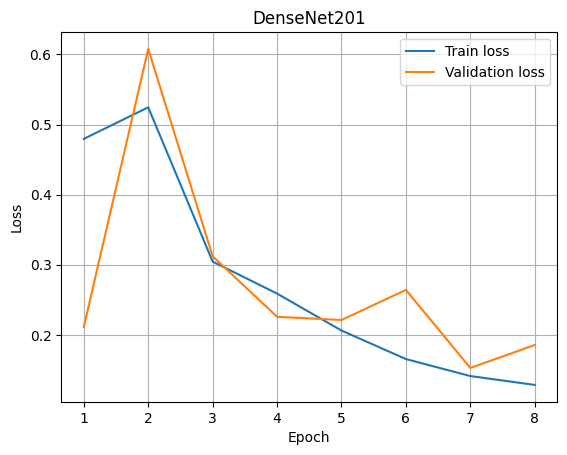

In [47]:
plot_loss_history(dn201_train_losses, dn201_val_losses, title='DenseNet201')

In [49]:
densenet201.load_state_dict(torch.load('/kaggle/working/DenseNet201_best_result.pt'))

<All keys matched successfully>

In [93]:
# torch.save(densenet201.state_dict(), '/kaggle/working/densenet201_full_data.pt')

In [56]:
# torch.save(densenet201.state_dict(), '/kaggle/working/densenet201_mini_data_with_hagrid.pt')

# Подсчет метрик моделей на тестовой выборке и их сравнение

In [61]:
def test_inference(model):
    '''Returns labels, predictions and probabilities of classes for each sample'''
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    all_labels = np.array([])
    all_preds = np.array([])
    all_proba = np.array([])
    model.eval()
    for data in tqdm(testloader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
    #         print(images.shape)
        outputs = F.softmax(model(images), dim=-1)
    #         print(densenet(images).shape)
        # the class with the highest energy is what we choose as prediction
    #         print(outputs.data)
    #         break
        _, predicted = torch.max(outputs.data, dim=-1)
    #         print(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels = np.append(all_labels, labels.cpu().numpy())
        all_preds = np.append(all_preds, predicted.cpu().numpy())
        all_proba = np.append(all_proba, outputs.detach().cpu().numpy())
        
    return all_labels, all_preds, all_proba

In [62]:
# target_names = le.inverse_transform(range(0, n_classes))

In [63]:
def plot_confusion_matrix(labels, preds, title):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(20, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=target_names)
    disp.plot()
    plt.xticks(rotation=30)
    plt.title(title)
    plt.show()

In [64]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

def plot_roc_auc(labels, proba):
    proba = proba.reshape((9985, 6))
    lb = LabelBinarizer()
    labels_one_hot = lb.fit_transform(labels)
    
#     print(labels_one_hot)
#     print(proba.ravel())
    
    display = RocCurveDisplay.from_predictions(
    labels_one_hot.ravel(),
    proba.ravel(),
    name="micro-average OvR",
    color="darkorange"
    )
    
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
    )
    

In [65]:
labels, dn121_preds, dn121_proba = test_inference(densenet)

100%|██████████| 327/327 [05:04<00:00,  1.07it/s]


In [66]:
_, mn_preds, mn_proba = test_inference(mobilenet)

100%|██████████| 327/327 [02:35<00:00,  2.10it/s]


In [67]:
_, dn201_preds, dn201_proba = test_inference(densenet201)

100%|██████████| 327/327 [03:00<00:00,  1.82it/s]


In [68]:
np.unique(labels).astype(int)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [69]:
labels[labels == 6] = 1
dn121_preds[dn121_preds == 6] = 1
mn_preds[mn_preds == 6] = 1
dn201_preds[dn201_preds == 6] = 1
target_names = le.inverse_transform(np.unique(labels).astype(int))

In [72]:
print('MobileNet metrics:')
print(classification_report(labels, mn_preds, target_names=target_names, digits=4))

MobileNet metrics:
                  precision    recall  f1-score   support

   Hand_cellular     0.9677    0.9636    0.9656      1400
  Hand_cigarette     0.8607    0.9780    0.9156       455
      Hand_empty     0.9225    0.9128    0.9176      1135
 Hand_over_wheel     0.8626    0.9086    0.8850       525
Hand_under_wheel     0.9904    0.9383    0.9637      1102
    Hand_unknown     0.9461    0.9391    0.9426      2841
        Not_hand     0.9823    0.9846    0.9834      2979

        accuracy                         0.9526     10437
       macro avg     0.9332    0.9464    0.9391     10437
    weighted avg     0.9535    0.9526    0.9528     10437



In [73]:
print('DenseNet121 metrics:')
print(classification_report(labels, dn121_preds, target_names=target_names, digits=4))

DenseNet121 metrics:
                  precision    recall  f1-score   support

   Hand_cellular     0.9524    0.9857    0.9688      1400
  Hand_cigarette     0.9802    0.8725    0.9233       455
      Hand_empty     0.9045    0.9427    0.9232      1135
 Hand_over_wheel     0.8881    0.9067    0.8973       525
Hand_under_wheel     0.9853    0.9746    0.9799      1102
    Hand_unknown     0.9684    0.9268    0.9471      2841
        Not_hand     0.9696    0.9943    0.9818      2979

        accuracy                         0.9574     10437
       macro avg     0.9498    0.9433    0.9459     10437
    weighted avg     0.9579    0.9574    0.9572     10437



In [74]:
print('DenseNet201 metrics:')
print(classification_report(labels, dn201_preds, target_names=target_names, digits=4))

DenseNet201 metrics:
                  precision    recall  f1-score   support

   Hand_cellular     0.9835    0.9807    0.9821      1400
  Hand_cigarette     0.9714    0.9714    0.9714       455
      Hand_empty     0.9723    0.9278    0.9495      1135
 Hand_over_wheel     0.8013    0.9752    0.8797       525
Hand_under_wheel     0.9854    0.9800    0.9827      1102
    Hand_unknown     0.9738    0.9416    0.9574      2841
        Not_hand     0.9821    0.9960    0.9890      2979

        accuracy                         0.9679     10437
       macro avg     0.9528    0.9675    0.9588     10437
    weighted avg     0.9698    0.9679    0.9683     10437



<Figure size 2000x400 with 0 Axes>

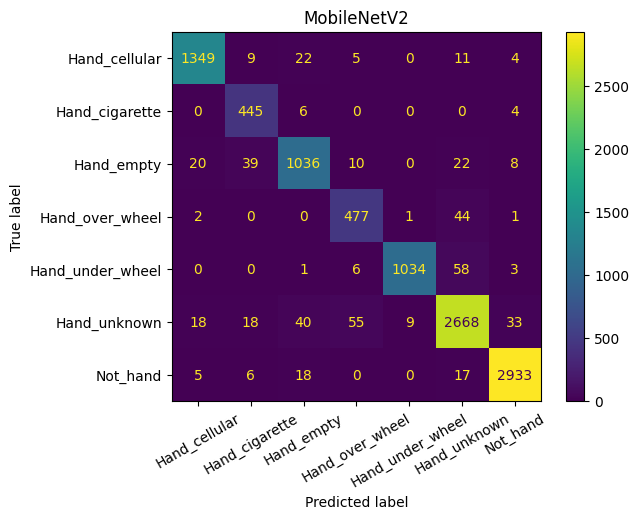

In [77]:
plot_confusion_matrix(labels, mn_preds, title='MobileNetV2')

<Figure size 2000x400 with 0 Axes>

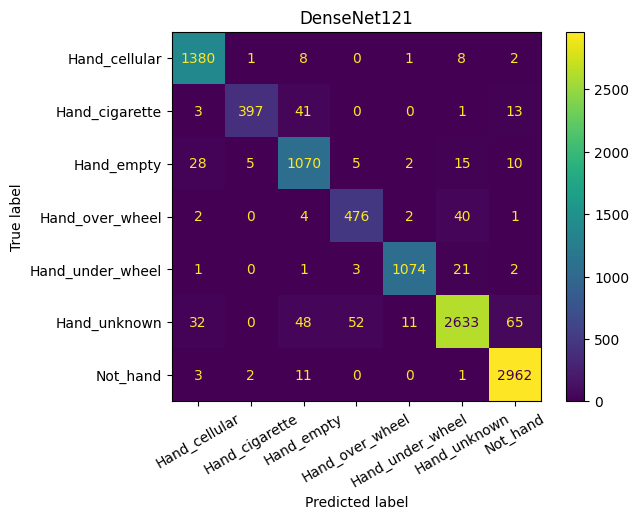

In [78]:
plot_confusion_matrix(labels, dn121_preds, title='DenseNet121')

<Figure size 2000x400 with 0 Axes>

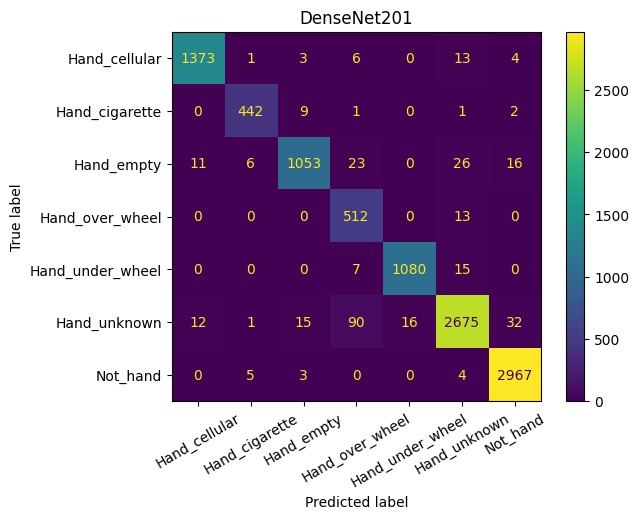

In [79]:
plot_confusion_matrix(labels, dn201_preds, title='DenseNet201')

# Рассчет среднего времени инференса моделей

In [80]:
#Функция для подсчета среднего времени обработки 1 изображения
import time

def measure_average_inference_time(model, device):
    test_single_loader = DataLoader(test_dataset, batch_size=1,
                                         shuffle=False)
    model.eval()
    time_sum = 0
    for data in tqdm(test_single_loader):
        start = time.time()
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
    #         print(images.shape)
        outputs = F.softmax(model(images), dim=-1)
    #         print(densenet(images).shape)
        # the class with the highest energy is what we choose as prediction
    #         print(outputs.data)
    #         break
        _, predicted = torch.max(outputs.data, dim=-1)
        end = time.time()
        time_sum += end - start
    return time_sum / len(test_single_loader)

In [81]:
#Функция для подсчета количества параметров модели
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [82]:
print('Количество параметров в MobileNet:')
count_parameters(mobilenet)

Количество параметров в MobileNet:


2234120

In [83]:
print('Количество параметров в DenseNet121:')
count_parameters(densenet)

Количество параметров в DenseNet121:


6962056

In [84]:
print('Количество параметров в DenseNet201:')
count_parameters(densenet201)

Количество параметров в DenseNet201:


18108296

In [63]:
#Среднее время обработки одного кадра MobileNetV2 на CPU
measure_average_inference_time(mobilenet.cpu(), 'cpu')

100%|██████████| 10437/10437 [08:24<00:00, 20.71it/s]


0.03155161677231971

In [64]:
#Среднее время обработки одного кадра MobileNetV2 на GPU P100
measure_average_inference_time(mobilenet.to('cuda'), 'cuda')

100%|██████████| 10437/10437 [04:11<00:00, 41.44it/s]


0.008934710872599342

In [70]:
#Среднее время обработки одного кадра DenseNet121 на CPU
measure_average_inference_time(densenet.cpu(), 'cpu')

100%|██████████| 10437/10437 [20:05<00:00,  8.66it/s]


0.09764227591175863

In [71]:
#Среднее время обработки одного кадра DenseNet121 на GPU P100
measure_average_inference_time(densenet.to('cuda'), 'cuda')

100%|██████████| 10437/10437 [06:22<00:00, 27.31it/s]


0.021775178529184373

In [65]:
#Среднее время обработки одного кадра DenseNet201 на CPU
measure_average_inference_time(densenet201.cpu(), 'cpu')

100%|██████████| 10437/10437 [32:14<00:00,  5.39it/s]


0.16680936531464555

In [66]:
#Среднее время обработки одного кадра DenseNet201 на GPU P100
measure_average_inference_time(densenet201.to('cuda'), 'cuda')

100%|██████████| 10437/10437 [10:17<00:00, 16.91it/s]


0.04097647053352247